In [1]:
from bloch import bloch
from bloch.bloch import kronigPenney
from bloch.bloch import evalModel
from bloch.bloch import coulombPotential

import torch
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'

Tesla V100-PCIE-32GB
11.6


In [2]:
energy_neurons = 64 # total energy layer neurons 
bloch_neurons = 128 # total bloch function layer neurons 

PATH_bz1 = 'blochmodels/transfer/aaaa'
#PATH_bz2 = 'blochmodels/transfer/bz2_retrain_2'
PATH_bz2 = 'blochmodels/transfer/bbbb'
PATH_bz3 = 'blochmodels/transfer/cccc'

bz1 = evalModel(energy_neurons, bloch_neurons, PATH_bz1)
bz2 = evalModel(energy_neurons, bloch_neurons, PATH_bz2)
bz3 = evalModel(energy_neurons, bloch_neurons, PATH_bz3)

Loaded model at blochmodels/transfer/aaaa
Loaded model at blochmodels/transfer/bbbb
Loaded model at blochmodels/transfer/cccc


In [3]:
class PeriodicPotential:
    'Doc: Class that defines a periodic potential in terms of various parameters.'
    def __init__(self,V0,b,a=1,N=5,num_int_pts=2001,potential='square',exp=30,ctr=0):
        self.potential_height = V0  ## The amplitude of the potential, from highest to lowest part.
        self.barrier_width = b  ## The width of the barrier. b must be less than a.
        self.lattice_constant = a  ## Taken to be 1 without loss of generality.
        self.num_Fourier = N  ## Number of "shells" in the Hamiltonian (-N ... N)
        self.num_V_G = 4*N+1 ## Number of Fourier components of the potential needed to populate the (2N+1)^2 Hamiltonian
        self.num_V_G_max = 2*N ## Number of "shells" in the potential expansion needed to generate the Hamiltonian
        self.V_G = np.zeros(self.num_V_G)
        self.num_int_pts = num_int_pts
        self.exponent = exp
        self.potential = potential
        self.center = ctr
        for i in range(self.num_V_G):
            self.V_G[i] = self.V_G_int(i-self.num_V_G_max)  ## pre-calculate the fourier coefficients of the potential (for speed)

    def V(self,x):
        xnew = np.abs(x)%self.lattice_constant  ## define a symmetric potential with period a
        if xnew > self.lattice_constant/2:
                xnew -= self.lattice_constant
        if self.potential=='square':
            if np.abs(xnew) <= self.barrier_width/2:  
                return self.potential_height  ## no vertical offset (avg not zero)
            else:
                return 0  ## 
        elif self.potential=='rounded':
            return self.potential_height/(1+((xnew-self.center)/(self.barrier_width/2))**self.exponent)
        elif self.potential=='coulomb':
            return -1/(0.2+(10*xnew)**2)
        else:
            return 0

    def V_G_int(self,m):  ## Integrate to determine the Fourier components of the potential
        xval = np.linspace(-self.lattice_constant/2,self.lattice_constant/2,self.num_int_pts)  
        Vx = [self.V(x) for x in xval]
        exp = np.exp(-1j*2*np.pi*m*xval/self.lattice_constant)
        integral = (1/self.lattice_constant)*np.trapz(Vx*exp,xval)
        return np.real_if_close(integral)

    def fourierVint(self,x,N):  ## Reconstruct the potential using the Fourier components determined by integration on the fly
        fV = 0
        for m in range(-N,N+1):
            fV += np.exp(-1j*2*np.pi*m*x/self.lattice_constant)*self.V_G_int(m)
        return np.real_if_close(fV)

    def fourierV(self,x):  ## Reconstruct the potential using the pre-calculated Fourier components
        fV = 0
        N = self.num_V_G_max
        for m in range(-N,N+1):
            fV += np.exp(-1j*2*np.pi*m*x/self.lattice_constant)*self.V_G[m+self.num_V_G_max]
        return np.real_if_close(fV)
class FourierSolution:
    'Doc: Class that defines the Fourier solution of the Schrodinger equation for a given periodic potential'
    def __init__(self,V):
        self.V = V
        #self.N = V.num_Fourier

    def Hmat(self,k):
        N = self.V.num_Fourier
        H = np.zeros((2*N+1,2*N+1))
        for i in range(2*N+1):
            for j in range(i+1,2*N+1):  ## This loop uses the precomputed Fourier components V_G[m]
                H[i,j] = self.V.V_G[j-i+self.V.num_V_G_max]  ## The form of this matrix is derived in Ashcroft and Mermin
                H[j,i] = self.V.V_G[j-i+self.V.num_V_G_max]
            H[i,i]=(1/2)*(k-2*np.pi*(i-N)/self.V.lattice_constant)**2+self.V.V_G[0+self.V.num_V_G_max]
        return H

    ## k & n must be single numbers, but x can be an array
    def u_kn(self,x,k,n):  ## n labels which evalue/evector; N--> 2N+1 total Fourier components
        N = self.V.num_Fourier
        evals, evecs = np.linalg.eig(self.Hmat(k))
        evals_sort = np.sort(evals)
        evecs_sort = evecs[:,np.argsort(evals)]
        uk = 0
        for i in range(2*N+1):
            uk += evecs_sort[i,n]*np.exp(-1j*2*np.pi*x*(i-N)/self.V.lattice_constant)
        return uk, evals_sort[n]

    def bands(self,k):
        evals, evecs = np.linalg.eig(self.Hmat(k))
        return np.sort(evals)

    def band_array(self,kvals,num_bands=5):
        ba = np.zeros((len(kvals),num_bands))
        for kind in range(len(kvals)):
            ba[kind] = self.bands(kvals[kind])[0:num_bands]
        return ba

In [4]:
PRW = PeriodicPotential(-5,1/4,potential='rounded',ctr=0,exp=4)
PSW = PeriodicPotential(-5,1/4,potential='square')
PCW = PeriodicPotential(-5,1/4,potential='coulomb')
soln_rounded = FourierSolution(PRW)
soln_coulomb = FourierSolution(PCW)
soln_square = FourierSolution(PSW)

## Plot Potentials

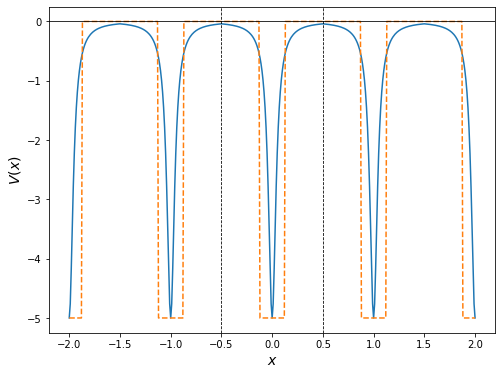

In [51]:
plt.figure(figsize = (8,6))    
xval = np.linspace(-2,2,401)
#plt.plot(xval,[PRW.V(x) for x in xval])
plt.plot(xval,[PCW.V(x) for x in xval])
plt.plot(xval,[PSW.V(x) for x in xval],ls='--')
plt.axhline(y=0,lw=.8,c='k')
plt.axvline(x=-1/2,lw=0.8,c='k',ls='--')
plt.axvline(x=1/2,lw=0.8,c='k',ls='--')
plt.ylabel('$V(x)$',fontsize=14)
plt.xlabel('$x$',fontsize=14);

## Plot Bands

(-5.0, 24.0)

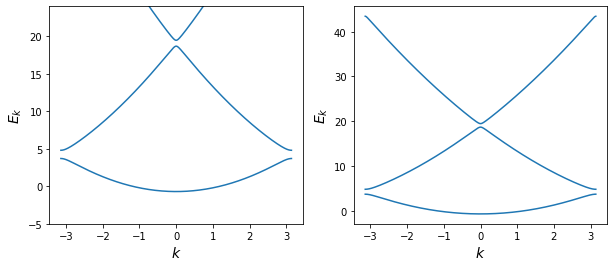

In [6]:
kvals = np.linspace(-np.pi,np.pi,1000)
num_bands = 3
plt.figure(figsize=(10,4))
plt.subplot(122)
for i in range(num_bands):
    plt.plot(kvals, soln_coulomb.band_array(kvals,num_bands)[:,i],ls='-',c='C0')
plt.xlabel('$k$',fontsize=14)
plt.ylabel('$E_k$',fontsize=14)
plt.subplot(121)
for i in range(num_bands):
    plt.plot(kvals, soln_coulomb.band_array(kvals,num_bands)[:,i],ls='-',c='C0')
    #plt.plot(kvals, soln_psw.band_array(kvals,num_bands)[:,i],ls='-',c='C1')
plt.ylabel('$E_k$',fontsize=14)
plt.xlabel('$k$',fontsize=14)

plt.ylim(-5,24)

# Plot Coulomb Bands vs Rounded Well

(-5.0, 15.0)

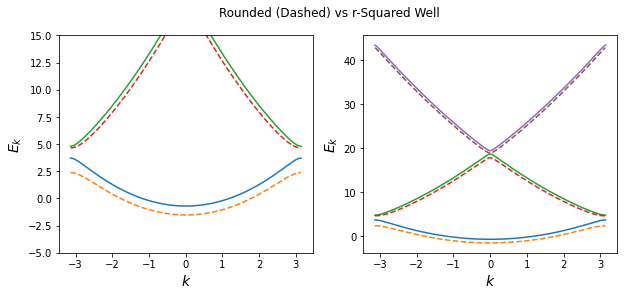

In [7]:
kvals = np.linspace(-np.pi,np.pi,1000)
num_bands = 3
plt.figure(figsize=(10,4))
plt.suptitle('Rounded (Dashed) vs r-Squared Well')
plt.subplot(122)
for i in range(num_bands):
    plt.plot(kvals, soln_coulomb.band_array(kvals,num_bands)[:,i],ls='-')
    plt.plot(kvals, soln_rounded.band_array(kvals,num_bands)[:,i],ls='--')
plt.xlabel('$k$',fontsize=14)
plt.ylabel('$E_k$',fontsize=14)
plt.subplot(121)
for i in range(num_bands):
    plt.plot(kvals, soln_coulomb.band_array(kvals,num_bands)[:,i],ls='-')
    plt.plot(kvals, soln_rounded.band_array(kvals,num_bands)[:,i],ls='--')
plt.ylabel('$E_k$',fontsize=14)
plt.xlabel('$k$',fontsize=14)

plt.ylim(-5,15)

# Plot model bands

In [8]:
x = torch.linspace(0,1,1000).reshape(-1,1).cuda()
k_1 = torch.linspace(0,np.pi,1000).reshape(-1,1).cuda()
k_2 = torch.linspace(np.pi,2*np.pi,1000).reshape(-1,1).cuda()
k_3 = torch.linspace(2*np.pi,3*np.pi,1000).reshape(-1,1).cuda()

bz1_bloch, bz1_en, nfe, delta  = bz1(x,k_1)
bz2_bloch, bz2_en, nfe, delta  = bz2(x,k_2)
bz3_bloch, bz3_en, nfe, delta  = bz3(x,k_3)

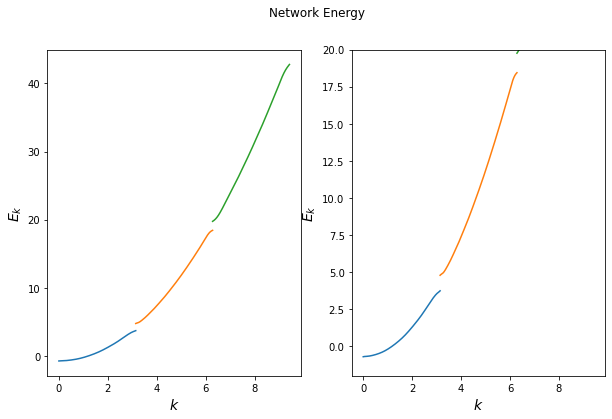

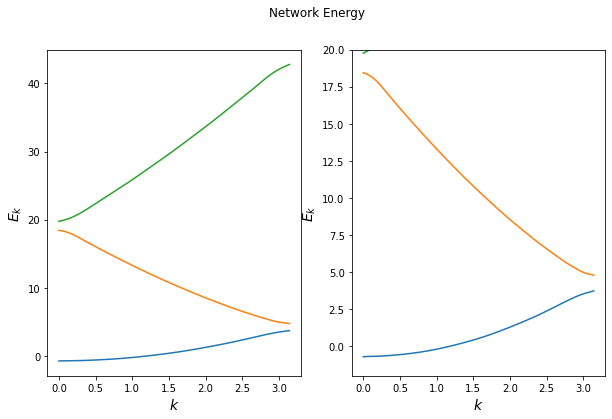

In [9]:
plt.figure(figsize=(10,6))
plt.suptitle('Network Energy')
plt.subplot(122)
plt.plot(k_1.cpu().detach().numpy(), bz1_en.cpu().detach().numpy(),ls='-')
plt.plot(k_2.cpu().detach().numpy(), bz2_en.cpu().detach().numpy(),ls='-')
plt.plot(k_3.cpu().detach().numpy(), bz3_en.cpu().detach().numpy(),ls='-')
plt.ylim(-2,20);
plt.xlabel('$k$',fontsize=14)
plt.ylabel('$E_k$',fontsize=14)
plt.subplot(121)
plt.plot(k_1.cpu().detach().numpy(), bz1_en.cpu().detach().numpy(),ls='-')
plt.plot(k_2.cpu().detach().numpy(), bz2_en.cpu().detach().numpy(),ls='-')
plt.plot(k_3.cpu().detach().numpy(), bz3_en.cpu().detach().numpy(),ls='-')
plt.ylabel('$E_k$',fontsize=14)
plt.xlabel('$k$',fontsize=14)


plt.figure(figsize=(10,6))
plt.suptitle('Network Energy')
plt.subplot(121)
plt.plot(k_1.cpu().detach().numpy(), bz1_en.cpu().detach().numpy(),ls='-')
plt.plot(-1*k_2.cpu().detach().numpy()+2*np.pi, bz2_en.cpu().detach().numpy(),ls='-')
plt.plot(k_3.cpu().detach().numpy()-2*np.pi, bz3_en.cpu().detach().numpy(),ls='-')
plt.xlabel('$k$',fontsize=14)
plt.ylabel('$E_k$',fontsize=14)
plt.subplot(122)
plt.plot(k_1.cpu().detach().numpy(), bz1_en.cpu().detach().numpy(),ls='-')
plt.plot(-1*k_2.cpu().detach().numpy()+2*np.pi, bz2_en.cpu().detach().numpy(),ls='-')
plt.plot(k_3.cpu().detach().numpy()-2*np.pi, bz3_en.cpu().detach().numpy(),ls='-')
plt.ylabel('$E_k$',fontsize=14)
plt.xlabel('$k$',fontsize=14)

plt.ylim(-2,20);

Text(0.5, 0, '$k$')

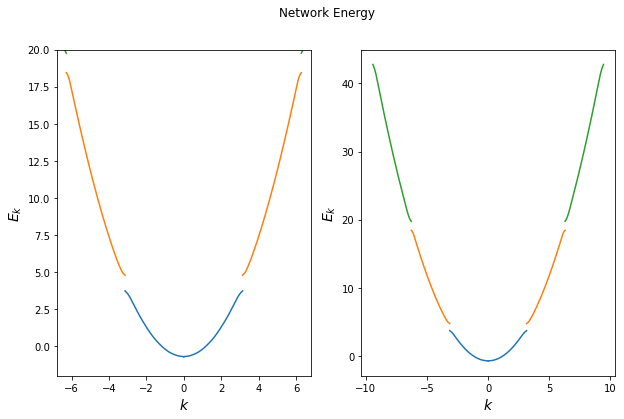

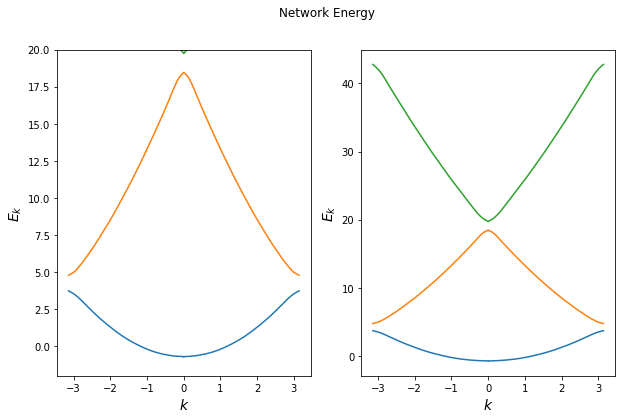

In [10]:
plt.figure(figsize=(10,6))
plt.suptitle('Network Energy')
plt.subplot(121)
plt.plot(k_1.cpu().detach().numpy(), bz1_en.cpu().detach().numpy(),ls='-',color='C0')
plt.plot(k_2.cpu().detach().numpy(), bz2_en.cpu().detach().numpy(),ls='-',color='C1')
plt.plot(k_3.cpu().detach().numpy(), bz3_en.cpu().detach().numpy(),ls='-',color='C2')
plt.plot(-1*k_1.cpu().detach().numpy(), bz1_en.cpu().detach().numpy(),ls='-',color='C0')
plt.plot(-1*k_2.cpu().detach().numpy(), bz2_en.cpu().detach().numpy(),ls='-',color='C1')
plt.plot(-1*k_3.cpu().detach().numpy(), bz3_en.cpu().detach().numpy(),ls='-',color='C2')
plt.ylim(-2,20);plt.xlim(-2*np.pi-0.5,2*np.pi+0.5)
plt.xlabel('$k$',fontsize=14)
plt.ylabel('$E_k$',fontsize=14)
plt.subplot(122)
plt.plot(k_1.cpu().detach().numpy(), bz1_en.cpu().detach().numpy(),ls='-',color='C0')
plt.plot(k_2.cpu().detach().numpy(), bz2_en.cpu().detach().numpy(),ls='-',color='C1')
plt.plot(k_3.cpu().detach().numpy(), bz3_en.cpu().detach().numpy(),ls='-',color='C2')
plt.plot(-1*k_1.cpu().detach().numpy(), bz1_en.cpu().detach().numpy(),ls='-',color='C0')
plt.plot(-1*k_2.cpu().detach().numpy(), bz2_en.cpu().detach().numpy(),ls='-',color='C1')
plt.plot(-1*k_3.cpu().detach().numpy(), bz3_en.cpu().detach().numpy(),ls='-',color='C2')
plt.ylabel('$E_k$',fontsize=14)
plt.xlabel('$k$',fontsize=14)

plt.figure(figsize=(10,6))
plt.suptitle('Network Energy')
plt.subplot(121)
plt.plot(k_1.cpu().detach().numpy(), bz1_en.cpu().detach().numpy(),ls='-',color='C0')
plt.plot(k_2.cpu().detach().numpy()-2*np.pi, bz2_en.cpu().detach().numpy(),ls='-',color='C1')
plt.plot(k_3.cpu().detach().numpy()-2*np.pi, bz3_en.cpu().detach().numpy(),ls='-',color='C2')
plt.plot(-1*k_1.cpu().detach().numpy(), bz1_en.cpu().detach().numpy(),ls='-',color='C0')
plt.plot(-1*k_2.cpu().detach().numpy()+2*np.pi, bz2_en.cpu().detach().numpy(),ls='-',color='C1')
plt.plot(-1*k_3.cpu().detach().numpy()+2*np.pi, bz3_en.cpu().detach().numpy(),ls='-',color='C2')
plt.ylim(-2,20)
plt.xlabel('$k$',fontsize=14)
plt.ylabel('$E_k$',fontsize=14)
plt.subplot(122)
plt.plot(k_1.cpu().detach().numpy(), bz1_en.cpu().detach().numpy(),ls='-',color='C0')
plt.plot(k_2.cpu().detach().numpy()-2*np.pi, bz2_en.cpu().detach().numpy(),ls='-',color='C1')
plt.plot(k_3.cpu().detach().numpy()-2*np.pi, bz3_en.cpu().detach().numpy(),ls='-',color='C2')
plt.plot(-1*k_1.cpu().detach().numpy(), bz1_en.cpu().detach().numpy(),ls='-',color='C0')
plt.plot(-1*k_2.cpu().detach().numpy()+2*np.pi, bz2_en.cpu().detach().numpy(),ls='-',color='C1')
plt.plot(-1*k_3.cpu().detach().numpy()+2*np.pi, bz3_en.cpu().detach().numpy(),ls='-',color='C2')
plt.ylabel('$E_k$',fontsize=14)
plt.xlabel('$k$',fontsize=14)

# Compare to Fourier solution

Text(0.5, 0, '$k$')

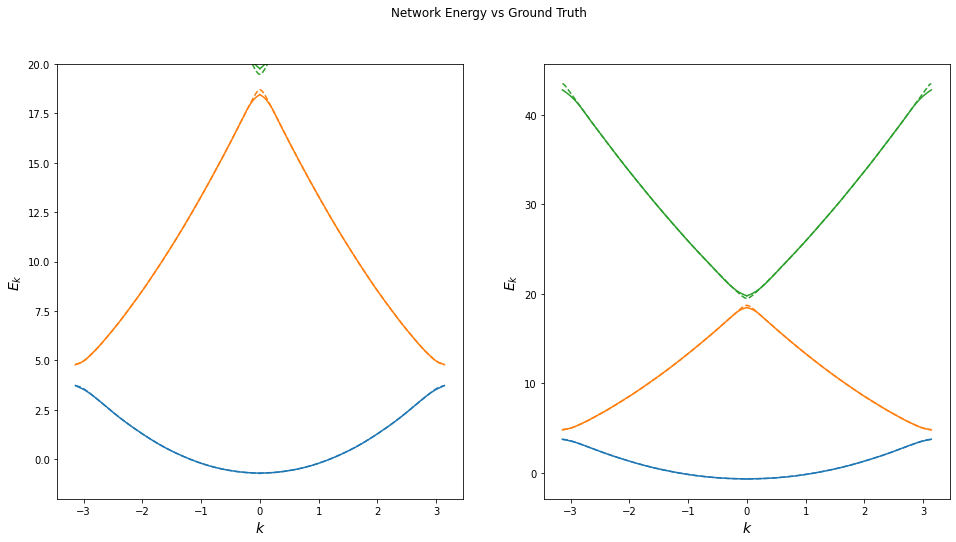

In [11]:
plt.figure(figsize=(16,8))
plt.suptitle('Network Energy vs Ground Truth')
plt.subplot(121)
plt.plot(k_1.cpu().detach().numpy(), bz1_en.cpu().detach().numpy(),ls='-',color='C0')
plt.plot(k_2.cpu().detach().numpy()-2*np.pi, bz2_en.cpu().detach().numpy(),ls='-',color='C1')
plt.plot(k_3.cpu().detach().numpy()-2*np.pi, bz3_en.cpu().detach().numpy(),ls='-',color='C2')
plt.plot(-1*k_1.cpu().detach().numpy(), bz1_en.cpu().detach().numpy(),ls='-',color='C0')
plt.plot(-1*k_2.cpu().detach().numpy()+2*np.pi, bz2_en.cpu().detach().numpy(),ls='-',color='C1')
plt.plot(-1*k_3.cpu().detach().numpy()+2*np.pi, bz3_en.cpu().detach().numpy(),ls='-',color='C2')
for i in range(num_bands):
    plt.plot(kvals, soln_coulomb.band_array(kvals,num_bands)[:,i],ls='--')
plt.ylim(-2,20)
plt.xlabel('$k$',fontsize=14)
plt.ylabel('$E_k$',fontsize=14)
plt.subplot(122)
plt.plot(k_1.cpu().detach().numpy(), bz1_en.cpu().detach().numpy(),ls='-',color='C0')
plt.plot(k_2.cpu().detach().numpy()-2*np.pi, bz2_en.cpu().detach().numpy(),ls='-',color='C1')
plt.plot(k_3.cpu().detach().numpy()-2*np.pi, bz3_en.cpu().detach().numpy(),ls='-',color='C2')
plt.plot(-1*k_1.cpu().detach().numpy(), bz1_en.cpu().detach().numpy(),ls='-',color='C0')
plt.plot(-1*k_2.cpu().detach().numpy()+2*np.pi, bz2_en.cpu().detach().numpy(),ls='-',color='C1')
plt.plot(-1*k_3.cpu().detach().numpy()+2*np.pi, bz3_en.cpu().detach().numpy(),ls='-',color='C2')
for i in range(num_bands):
    plt.plot(kvals, soln_coulomb.band_array(kvals,num_bands)[:,i],ls='--')
plt.ylabel('$E_k$',fontsize=14)
plt.xlabel('$k$',fontsize=14)

Text(0.5, 0, '$k$')

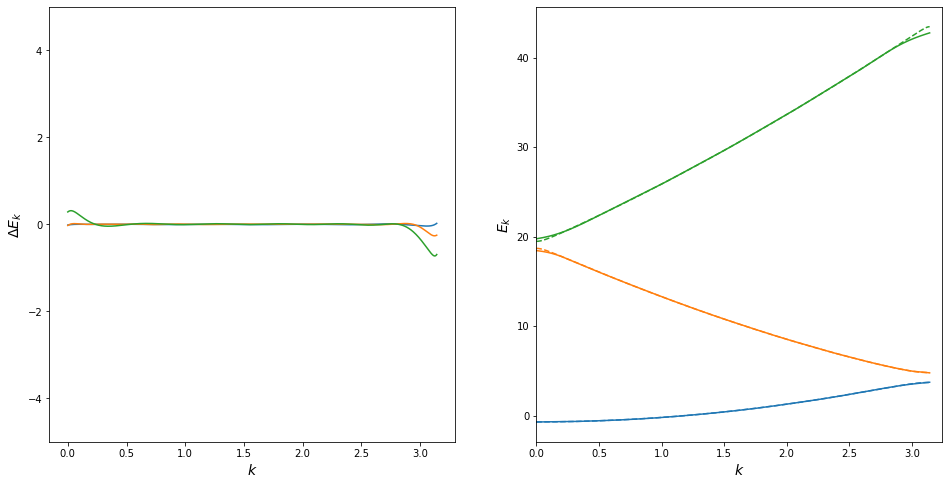

In [12]:
kvals = np.linspace(0,np.pi,1000)
plt.figure(figsize=(16,8))
plt.suptitle('')
plt.subplot(121)
#plt.plot(kvals, bz1_en.cpu().detach().numpy(),ls='-',color='C0')

#plt.plot(kvals, soln_coulomb.band_array(kvals+np.pi,2)[:,1],ls='-',color='C1')

plt.plot(kvals,(bz1_en.cpu().detach().numpy()-soln_coulomb.band_array(kvals,1))[:,0])
plt.plot(kvals,(bz2_en.cpu().detach().numpy()-soln_coulomb.band_array(kvals+np.pi,2))[:,1])
plt.plot(kvals,(bz3_en.cpu().detach().numpy()-soln_coulomb.band_array(kvals+2*np.pi,3))[:,2])
#plt.plot(k_2.cpu().detach().numpy()-2*np.pi, bz2_en.cpu().detach().numpy(),ls='-',color='C1')

# plt.plot(k_2.cpu().detach().numpy()-2*np.pi, bz2_en.cpu().detach().numpy(),ls='-',color='C1')
# plt.plot(k_3.cpu().detach().numpy()-2*np.pi, bz3_en.cpu().detach().numpy(),ls='-',color='C2')
# plt.plot(-1*k_1.cpu().detach().numpy(), bz1_en.cpu().detach().numpy(),ls='-',color='C0')
# plt.plot(-1*k_2.cpu().detach().numpy()+2*np.pi, bz2_en.cpu().detach().numpy(),ls='-',color='C1')
# plt.plot(-1*k_3.cpu().detach().numpy()+2*np.pi, bz3_en.cpu().detach().numpy(),ls='-',color='C2')
# for i in range(num_bands):
#     plt.plot(kvals, soln_coulomb.band_array(kvals,num_bands)[:,i],ls='--')
plt.ylim(-5,5)
plt.xlabel('$k$',fontsize=14)
plt.ylabel('$\Delta E_k$',fontsize=14)
plt.subplot(122)
plt.plot(k_1.cpu().detach().numpy(), bz1_en.cpu().detach().numpy(),ls='-',color='C0')
plt.plot(k_2.cpu().detach().numpy()-2*np.pi, bz2_en.cpu().detach().numpy(),ls='-',color='C1')
plt.plot(k_3.cpu().detach().numpy()-2*np.pi, bz3_en.cpu().detach().numpy(),ls='-',color='C2')
plt.plot(-1*k_1.cpu().detach().numpy(), bz1_en.cpu().detach().numpy(),ls='-',color='C0')
plt.plot(-1*k_2.cpu().detach().numpy()+2*np.pi, bz2_en.cpu().detach().numpy(),ls='-',color='C1')
plt.plot(-1*k_3.cpu().detach().numpy()+2*np.pi, bz3_en.cpu().detach().numpy(),ls='-',color='C2')
for i in range(num_bands):
    plt.plot(kvals, soln_coulomb.band_array(kvals,num_bands)[:,i],ls='--')
plt.xlim(0,np.pi+0.1)
plt.ylabel('$E_k$',fontsize=14)
plt.xlabel('$k$',fontsize=14)

Text(0, 0.5, '|$\\Delta E_k$|')

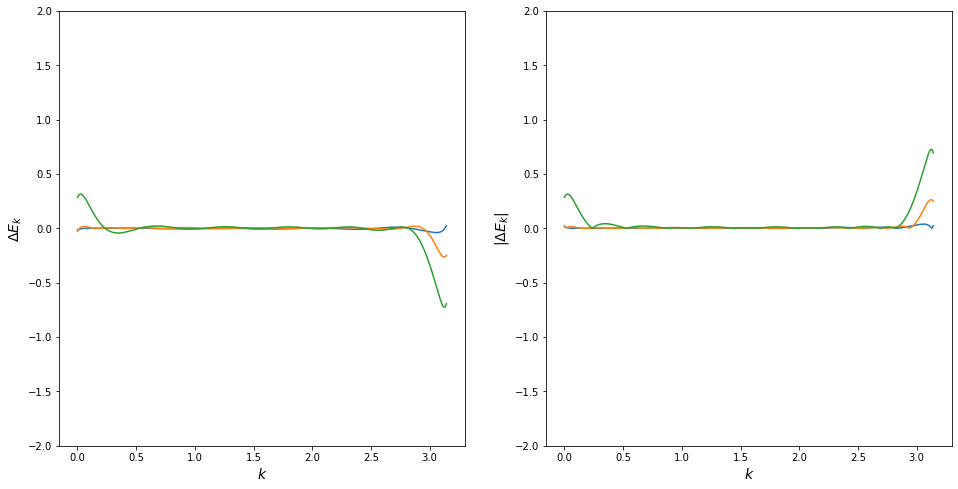

In [13]:
kvals = np.linspace(0,np.pi,1000)
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.plot(kvals,(bz1_en.cpu().detach().numpy()-soln_coulomb.band_array(kvals,1))[:,0])
plt.plot(kvals,(bz2_en.cpu().detach().numpy()-soln_coulomb.band_array(kvals+np.pi,2))[:,1])
plt.plot(kvals,(bz3_en.cpu().detach().numpy()-soln_coulomb.band_array(kvals+2*np.pi,3))[:,2])

plt.ylim(-2,2)
plt.xlabel('$k$',fontsize=14)
plt.ylabel('$\Delta E_k$',fontsize=14)

plt.subplot(122)
plt.plot(kvals,abs((bz1_en.cpu().detach().numpy()-soln_coulomb.band_array(kvals,1))[:,0]))
plt.plot(kvals,abs((bz2_en.cpu().detach().numpy()-soln_coulomb.band_array(kvals+np.pi,2))[:,1]))
plt.plot(kvals,abs((bz3_en.cpu().detach().numpy()-soln_coulomb.band_array(kvals+2*np.pi,3))[:,2]))

plt.ylim(-2,2)
plt.xlabel('$k$',fontsize=14)
plt.ylabel('|$\Delta E_k$|',fontsize=14)

Text(0, 0.5, '|$\\Delta E_k$|')

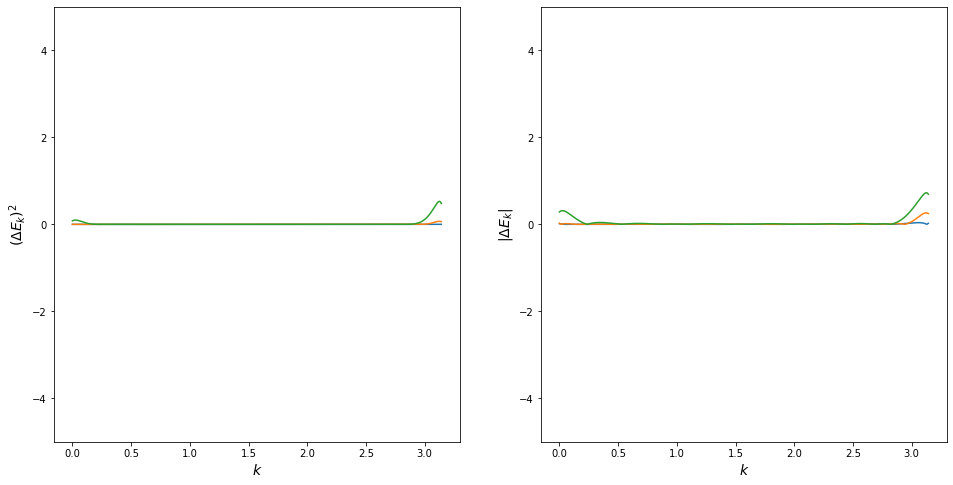

In [14]:
kvals = np.linspace(0,np.pi,1000)
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.plot(kvals,((bz1_en.cpu().detach().numpy()-soln_coulomb.band_array(kvals,1))[:,0])**2)
plt.plot(kvals,((bz2_en.cpu().detach().numpy()-soln_coulomb.band_array(kvals+np.pi,2))[:,1])**2)
plt.plot(kvals,((bz3_en.cpu().detach().numpy()-soln_coulomb.band_array(kvals+2*np.pi,3))[:,2])**2)

plt.ylim(-5,5)
plt.xlabel('$k$',fontsize=14)
plt.ylabel('$(\Delta E_k)^2$',fontsize=14)

plt.subplot(122)
plt.plot(kvals,abs((bz1_en.cpu().detach().numpy()-soln_coulomb.band_array(kvals,1))[:,0]))
plt.plot(kvals,abs((bz2_en.cpu().detach().numpy()-soln_coulomb.band_array(kvals+np.pi,2))[:,1]))
plt.plot(kvals,abs((bz3_en.cpu().detach().numpy()-soln_coulomb.band_array(kvals+2*np.pi,3))[:,2]))

plt.ylim(-5,5)
plt.xlabel('$k$',fontsize=14)
plt.ylabel('|$\Delta E_k$|',fontsize=14)

Text(0.5, 1.0, 'Abs Error')

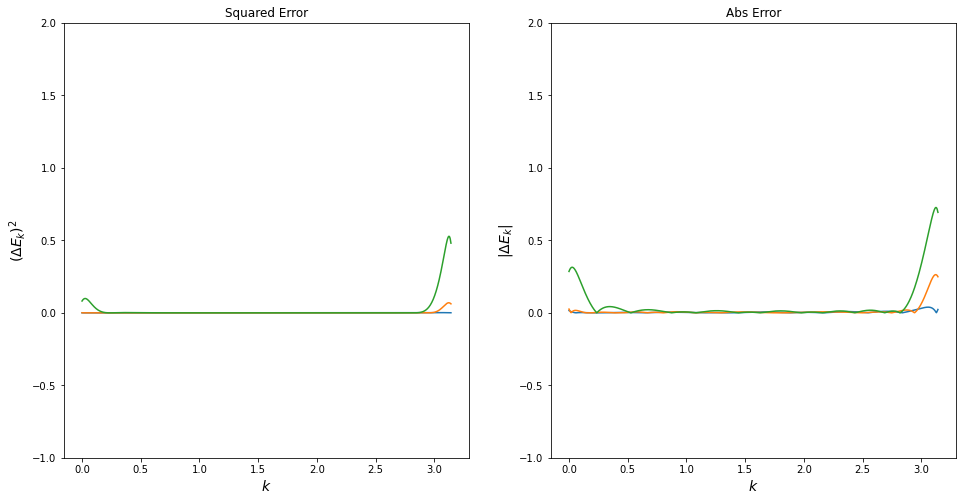

In [15]:
kvals = np.linspace(0,np.pi,1000)
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.plot(kvals,((bz1_en.cpu().detach().numpy()-soln_coulomb.band_array(kvals,1))[:,0])**2)
plt.plot(kvals,((bz2_en.cpu().detach().numpy()-soln_coulomb.band_array(kvals+np.pi,2))[:,1])**2)
plt.plot(kvals,((bz3_en.cpu().detach().numpy()-soln_coulomb.band_array(kvals+2*np.pi,3))[:,2])**2)

plt.ylim(-1,2)
plt.xlabel('$k$',fontsize=14)
plt.ylabel('$(\Delta E_k)^2$',fontsize=14)
plt.title('Squared Error')
plt.subplot(122)
plt.plot(kvals,abs((bz1_en.cpu().detach().numpy()-soln_coulomb.band_array(kvals,1))[:,0]))
plt.plot(kvals,abs((bz2_en.cpu().detach().numpy()-soln_coulomb.band_array(kvals+np.pi,2))[:,1]))
plt.plot(kvals,abs((bz3_en.cpu().detach().numpy()-soln_coulomb.band_array(kvals+2*np.pi,3))[:,2]))

plt.ylim(-1,2)
plt.xlabel('$k$',fontsize=14)
plt.ylabel('|$\Delta E_k$|',fontsize=14)
plt.title('Abs Error')

Text(0.5, 1.0, '% Error |$\\frac{Truth}{Network} $|')

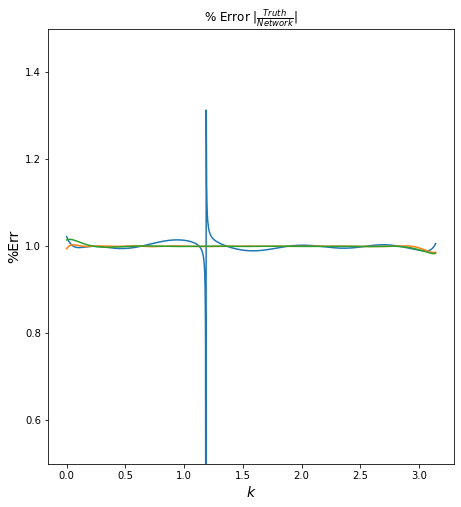

In [16]:
# Hacky offset to resolve zero crossing 

E_0 = bz1_en.cpu().detach().numpy()[0][0] ; epsilon = 0.5

OFFSET_EN = E_0 + epsilon

kvals = np.linspace(0,np.pi,1000)
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.plot(kvals,abs((bz1_en.cpu().detach().numpy()/soln_coulomb.band_array(kvals,1))[:,0]))
plt.plot(kvals,abs((bz2_en.cpu().detach().numpy()/soln_coulomb.band_array(kvals+np.pi,2))[:,1]))
plt.plot(kvals,abs((bz3_en.cpu().detach().numpy()/soln_coulomb.band_array(kvals+2*np.pi,3))[:,2]))

plt.ylim(0.5,1.5)
plt.xlabel('$k$',fontsize=14)
plt.ylabel('%Err',fontsize=14)
plt.title(r'% Error |$\frac{Truth}{Network} $|')
# plt.subplot(122)
# plt.plot(kvals,((soln_coulomb.band_array(kvals,1)/bz1_en.cpu().detach().numpy())[:,0])**2)
# plt.plot(kvals,((soln_coulomb.band_array(kvals+np.pi,2)/bz2_en.cpu().detach().numpy())[:,1])**2)
# plt.plot(kvals,((soln_coulomb.band_array(kvals+2*np.pi,3)/bz3_en.cpu().detach().numpy())[:,2])**2)

# plt.ylim(0,3)
# plt.xlabel('$k$',fontsize=14)
# plt.ylabel('%Err',fontsize=14)
# plt.title('% Error (Model/Numeric)')

Text(0.5, 1.0, '% Error ($\\frac{NN-Truth}{Truth} $)')

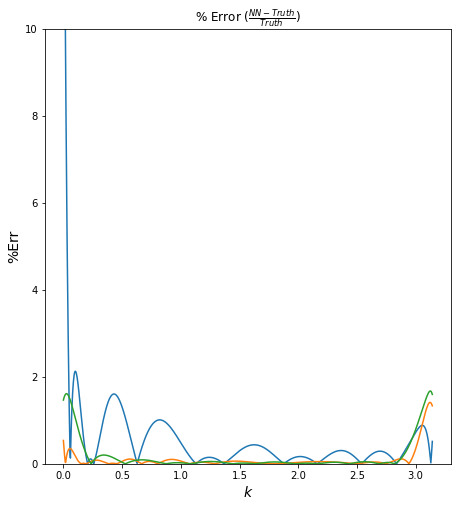

In [17]:
kvals = np.linspace(0,np.pi,1000)
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.plot(kvals,100*abs((((OFFSET_EN+1+bz1_en.cpu().detach().numpy())-(OFFSET_EN+1+soln_coulomb.band_array(kvals,1)))/(OFFSET_EN+1+soln_coulomb.band_array(kvals,1)))[:,0]),color='C0')
plt.plot(kvals,100*abs(((bz2_en.cpu().detach().numpy()-soln_coulomb.band_array(kvals+np.pi,2))/soln_coulomb.band_array(kvals+np.pi,2))[:,1]),color='C1')
plt.plot(kvals,100*abs(((bz3_en.cpu().detach().numpy()-soln_coulomb.band_array(kvals+2*np.pi,3))/soln_coulomb.band_array(kvals+2*np.pi,3))[:,2]),color='C2')

plt.ylim(0,10)
plt.xlabel('$k$',fontsize=14)
plt.ylabel('%Err',fontsize=14)
plt.title(r'% Error ($\frac{NN-Truth}{Truth} $)')
# plt.subplot(122)
# plt.plot(kvals,((soln_coulomb.band_array(kvals,1)/bz1_en.cpu().detach().numpy())[:,0])**2)
# plt.plot(kvals,((soln_coulomb.band_array(kvals+np.pi,2)/bz2_en.cpu().detach().numpy())[:,1])**2)
# plt.plot(kvals,((soln_coulomb.band_array(kvals+2*np.pi,3)/bz3_en.cpu().detach().numpy())[:,2])**2)

# plt.ylim(0,3)
# plt.xlabel('$k$',fontsize=14)
# plt.ylabel('%Err',fontsize=14)
# plt.title('% Error (Model/Numeric)')

# Plot Wavefunctions

In [18]:
# xval = np.linspace(-1/2,1/2,1000)
# kvals = np.linspace(0,np.pi,10)
# knum = len(kvals)
# fig, ax = plt.subplots(knum, 1, figsize=(8,4*knum), sharey=True)
# modelxs = torch.linspace(-2,2,1000).reshape(-1,1).cuda()

# for i in range(len(kvals)):
#     for n in range(1):
#         modelks = torch.linspace(kvals[i],kvals[i],1000).reshape(-1,1).cuda()
#         bloch, ek, nfe, delta  = bz1(modelxs,modelks)
#         ukx, en = soln_coulomb.u_kn(xval,kvals[i],n)

#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,0].reshape(-1,1).cpu().detach().numpy(),color='C0')
#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,1].reshape(-1,1).cpu().detach().numpy(),color='C1')
#         ax[i].plot(xval+0.5,np.real(ukx),ls='--')
#         ax[i].plot(xval+0.5,np.imag(ukx),ls='--')
#         #ax[i].set_xlim(-1,1)
#         ax[i].set_xlim(0,1)
#         ax[i].axvline(x=-0.5,ls=':',lw=0.8,c='k')
#         ax[i].axvline(x=0.5,ls=':',lw=0.8,c='k')
#         ax[i].set_title('E = {:6.3f}'.format(ek.cpu().detach().mean()),fontsize=14)
#     ax[i].set_ylabel('$u_{k}^{n}(x)$',fontsize=14)
# #for i in range(1):
# ax[-1].set_xlabel('$x$',fontsize=14)
# for i in range(knum):
#     ax[i].annotate('$k=${:4.2}'.format(kvals[i]),(1.05,0.5),xycoords='axes fraction',fontsize=14)

In [19]:
# kvals = np.linspace(0,np.pi,10)
# knum = len(kvals)
# fig, ax = plt.subplots(knum, 1, figsize=(8,4*knum), sharey=True)
# modelxs = torch.linspace(-2,2,1000).reshape(-1,1).cuda()

# for i in range(len(kvals)):
#     for n in range(1):
#         modelks = torch.linspace(kvals[i],kvals[i],1000).reshape(-1,1).cuda()
#         bloch, ek, nfe, delta  = bz1(modelxs,modelks)
#         ukx, en = soln_coulomb.u_kn(xval,kvals[i],n)

#         ax[i].plot(modelxs.cpu().detach().numpy(),abs(bloch[:,0].reshape(-1,1).cpu().detach().numpy()),color='C0')
#         ax[i].plot(modelxs.cpu().detach().numpy(),abs(bloch[:,1].reshape(-1,1).cpu().detach().numpy()),color='C1')
#         ax[i].plot(xval+0.5,abs(np.real(ukx)),ls='--')
#         ax[i].plot(xval+0.5,abs(np.imag(ukx)),ls='--')
#         #ax[i].set_xlim(-1,1)
#         ax[i].set_xlim(0,1)
#         ax[i].axvline(x=-0.5,ls=':',lw=0.8,c='k')
#         ax[i].axvline(x=0.5,ls=':',lw=0.8,c='k')
#         ax[i].set_title('E = {:6.3f}'.format(ek.cpu().detach().mean()),fontsize=14)
#     ax[i].set_ylabel('$u_{k}^{n}(x)$',fontsize=14)
# #for i in range(1):
# ax[-1].set_xlabel('$x$',fontsize=14)
# for i in range(knum):
#     ax[i].annotate('$k=${:4.2}'.format(kvals[i]),(1.05,0.5),xycoords='axes fraction',fontsize=14)

In [20]:
# kvals = np.linspace(0,np.pi,10)
# knum = len(kvals)
# fig, ax = plt.subplots(knum, 1, figsize=(8,4*knum), sharey=True)
# modelxs = torch.linspace(-2,2,1000).reshape(-1,1).cuda()

# for i in range(len(kvals)):
#     for n in range(1):
#         modelks = torch.linspace(kvals[i],kvals[i],1000).reshape(-1,1).cuda()
#         bloch, ek, nfe, delta  = bz1(modelxs,modelks)
#         ukx, en = soln_coulomb.u_kn(xval,kvals[i],n)

#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,0].reshape(-1,1).cpu().detach().numpy(),color='C0')
#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,1].reshape(-1,1).cpu().detach().numpy(),color='C1')
#         #ax[i].set_xlim(-1,1)
#         ax[i].set_xlim(0,1)
#         ax[i].axvline(x=-0.5,ls=':',lw=0.8,c='k')
#         ax[i].axvline(x=0.5,ls=':',lw=0.8,c='k')
#         ax[i].set_title('E = {:6.3f}'.format(ek.cpu().detach().mean()),fontsize=14)
#     ax[i].set_ylabel('$u_{k}^{n}(x)$',fontsize=14)
# #for i in range(1):
# ax[-1].set_xlabel('$x$',fontsize=14)
# for i in range(knum):
#     ax[i].annotate('$k=${:4.2}'.format(kvals[i]),(1.05,0.5),xycoords='axes fraction',fontsize=14)

# Plot Mag Squared

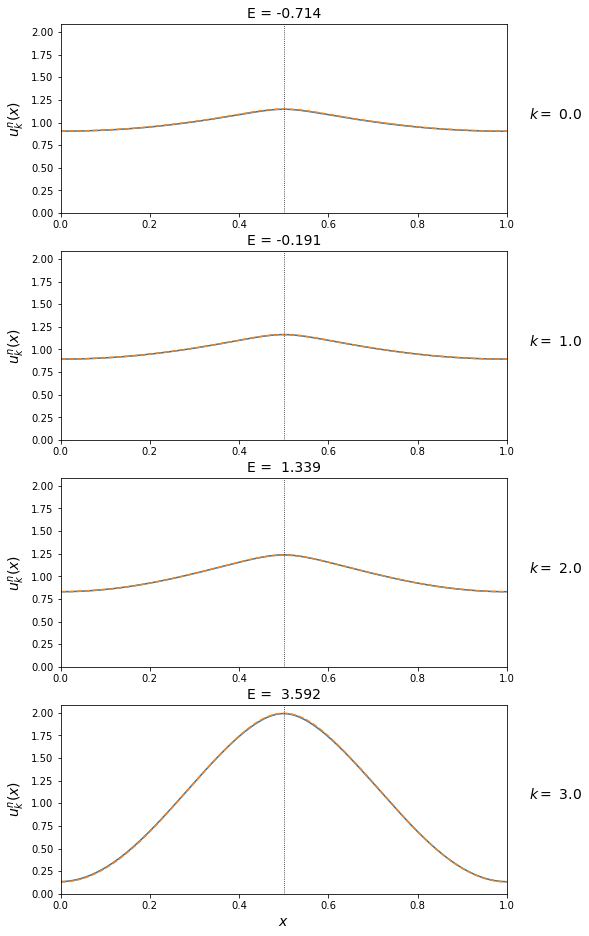

In [21]:
xval = np.linspace(0,1,1000); phase_offset = 0.5
numks = 4
kvals = np.linspace(0,np.pi-0.1,numks)
knum = len(kvals)
fig, ax = plt.subplots(knum, 1, figsize=(8,4*knum), sharey=True)
modelxs = torch.linspace(-2,2,1000).reshape(-1,1).cuda()

for i in range(len(kvals)):
    for n in range(1):
        modelks = torch.linspace(kvals[i],kvals[i],1000).reshape(-1,1).cuda()
        bloch, ek, nfe, delta  = bz1(modelxs,modelks)
        ukx, en = soln_coulomb.u_kn(xval+phase_offset,kvals[i],n)

#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,0].reshape(-1,1).cpu().detach().numpy(),color='C0')
#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,1].reshape(-1,1).cpu().detach().numpy(),color='C1')
        ax[i].plot(modelxs.cpu().detach().numpy(),(bloch[:,0].reshape(-1,1).cpu().detach().numpy()**2)+(bloch[:,1].reshape(-1,1).cpu().detach().numpy()**2),color='C0')
        ax[i].plot(xval,np.abs(ukx)**2,ls='--',color='C1')
        #ax[i].plot(xval+0.5,np.imag(ukx),ls='--')
        #ax[i].set_xlim(-1,1)
        ax[i].set_xlim(0,1)
        ax[i].axvline(x=-0.5,ls=':',lw=0.8,c='k')
        ax[i].axvline(x=0.5,ls=':',lw=0.8,c='k')
        ax[i].set_title('E = {:6.3f}'.format(ek.cpu().detach().mean()),fontsize=14)
    ax[i].set_ylabel('$u_{k}^{n}(x)$',fontsize=14)
#for i in range(1):
ax[-1].set_xlabel('$x$',fontsize=14)
for i in range(knum):
    ax[i].annotate('$k=${:4.2}'.format(kvals[i]),(1.05,0.5),xycoords='axes fraction',fontsize=14)

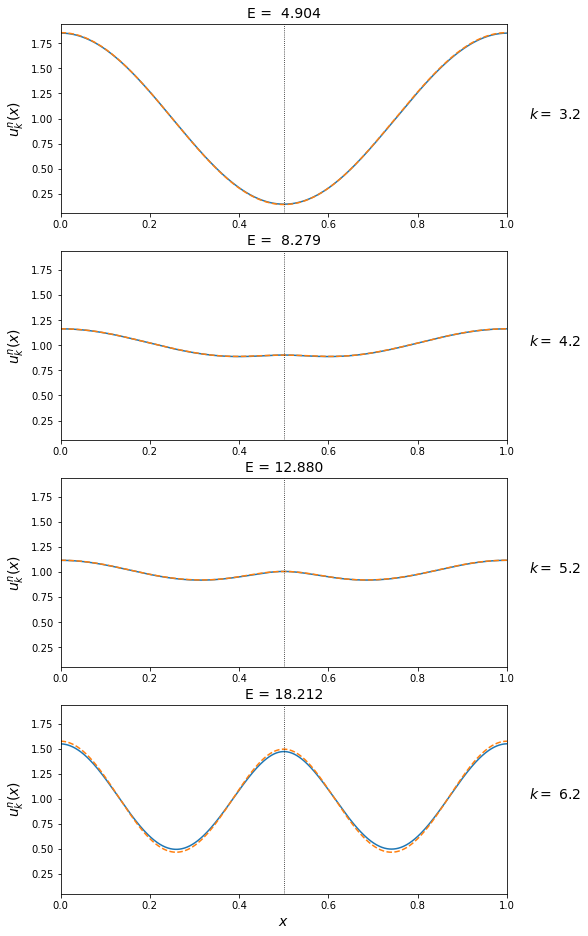

In [22]:
kvals = np.linspace(np.pi+0.1,2*np.pi-0.1,numks)
knum = len(kvals)
fig, ax = plt.subplots(knum, 1, figsize=(8,4*knum), sharey=True)
modelxs = torch.linspace(0,1,1000).reshape(-1,1).cuda()

for i in range(len(kvals)):
    for n in range(1):
        modelks = torch.linspace(kvals[i],kvals[i],1000).reshape(-1,1).cuda()
        bloch, ek, nfe, delta  = bz2(modelxs,modelks)
        ukx, en = soln_coulomb.u_kn(xval+phase_offset,kvals[i],1)

#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,0].reshape(-1,1).cpu().detach().numpy(),color='C0')
#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,1].reshape(-1,1).cpu().detach().numpy(),color='C1')

#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,0].reshape(-1,1).cpu().detach().numpy(),color='C0')
#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,1].reshape(-1,1).cpu().detach().numpy(),color='C1')
        ax[i].plot(modelxs.cpu().detach().numpy(),(bloch[:,0].reshape(-1,1).cpu().detach().numpy()**2)+(bloch[:,1].reshape(-1,1).cpu().detach().numpy()**2),color='C0')
        ax[i].plot(xval,np.abs(ukx)**2,ls='--',color='C1')
        ax[i].set_xlim(0,1)
        ax[i].axvline(x=-0.5,ls=':',lw=0.8,c='k')
        ax[i].axvline(x=0.5,ls=':',lw=0.8,c='k')
        ax[i].set_title('E = {:6.3f}'.format(ek.cpu().detach().mean()),fontsize=14)
    ax[i].set_ylabel('$u_{k}^{n}(x)$',fontsize=14)
#for i in range(1):
ax[-1].set_xlabel('$x$',fontsize=14)
for i in range(knum):
    ax[i].annotate('$k=${:4.2}'.format(kvals[i]),(1.05,0.5),xycoords='axes fraction',fontsize=14)

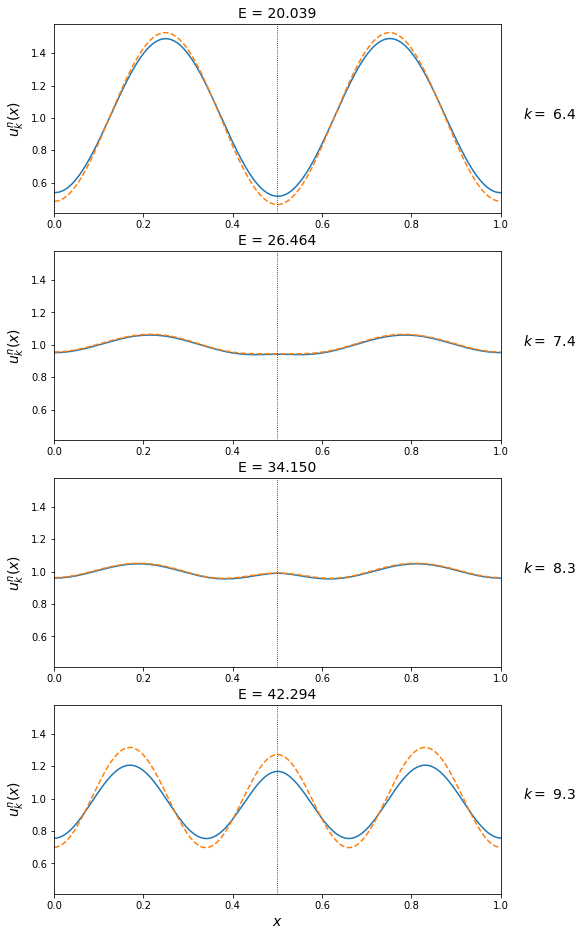

In [23]:
kvals = np.linspace(2*np.pi+0.1,3*np.pi-0.1,numks)
knum = len(kvals)
fig, ax = plt.subplots(knum, 1, figsize=(8,4*knum), sharey=True)
modelxs = torch.linspace(0,1,1000).reshape(-1,1).cuda()

for i in range(len(kvals)):
    for n in range(1):
        modelks = torch.linspace(kvals[i],kvals[i],1000).reshape(-1,1).cuda()
        bloch, ek, nfe, delta  = bz3(modelxs,modelks)
        ukx, en = soln_coulomb.u_kn(xval+phase_offset,kvals[i],2)

#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,0].reshape(-1,1).cpu().detach().numpy(),color='C0')
#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,1].reshape(-1,1).cpu().detach().numpy(),color='C1')

#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,0].reshape(-1,1).cpu().detach().numpy(),color='C0')
#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,1].reshape(-1,1).cpu().detach().numpy(),color='C1')
        ax[i].plot(modelxs.cpu().detach().numpy(),(bloch[:,0].reshape(-1,1).cpu().detach().numpy()**2)+(bloch[:,1].reshape(-1,1).cpu().detach().numpy()**2),color='C0')
        ax[i].plot(xval,np.abs(ukx)**2,ls='--',color='C1')
        ax[i].set_xlim(0,1)
        ax[i].axvline(x=-0.5,ls=':',lw=0.8,c='k')
        ax[i].axvline(x=0.5,ls=':',lw=0.8,c='k')
        ax[i].set_title('E = {:6.3f}'.format(ek.cpu().detach().mean()),fontsize=14)
    ax[i].set_ylabel('$u_{k}^{n}(x)$',fontsize=14)
#for i in range(1):
ax[-1].set_xlabel('$x$',fontsize=14)
for i in range(knum):
    ax[i].annotate('$k=${:4.2}'.format(kvals[i]),(1.05,0.5),xycoords='axes fraction',fontsize=14)

# Plot Mag Squared Error

In [24]:
# kvals = np.linspace(2*np.pi+0.1,3*np.pi-0.1,10)
# knum = len(kvals)
# fig, ax = plt.subplots(knum, 1, figsize=(8,4*knum), sharey=True)
# modelxs = torch.linspace(0,1,1000).reshape(-1,1).cuda()

# for i in range(len(kvals)):
#     for n in range(1):
#         modelks = torch.linspace(kvals[i],kvals[i],1000).reshape(-1,1).cuda()
#         bloch, ek, nfe, delta  = bz3(modelxs,modelks)
#         ukx, en = soln_coulomb.u_kn(xval+0.5,kvals[i],2)

# #         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,0].reshape(-1,1).cpu().detach().numpy(),color='C0')
# #         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,1].reshape(-1,1).cpu().detach().numpy(),color='C1')

# #         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,0].reshape(-1,1).cpu().detach().numpy(),color='C0')
# #         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,1].reshape(-1,1).cpu().detach().numpy(),color='C1')
#         ax[i].plot(modelxs.cpu().detach().numpy(),(bloch[:,0].reshape(-1,1).cpu().detach().numpy()**2)+(bloch[:,1].reshape(-1,1).cpu().detach().numpy()**2),color='C0')
#         ax[i].plot(xval,(np.real(ukx)**2+np.imag(ukx)**2),ls='--',color='C1')
        
#         umagsquared = (bloch[:,0].reshape(-1,1).cpu().detach().numpy()**2)+(bloch[:,1].reshape(-1,1).cpu().detach().numpy()**2)
#         unummagsquared = np.real(ukx)**2+np.imag(ukx)**2
#         ax[i].plot(xval,(unummagsquared-umagsquared)[:,i]**2,color='C2')
#         ax[i].set_xlim(0,1)
#         ax[i].axvline(x=-0.5,ls=':',lw=0.8,c='k')
#         ax[i].axvline(x=0.5,ls=':',lw=0.8,c='k')
#         ax[i].set_title('E = {:6.3f}'.format(ek.cpu().detach().mean()),fontsize=14)
#     ax[i].set_ylabel('$u_{k}^{n}(x)$',fontsize=14)
# #for i in range(1):
# ax[-1].set_xlabel('$x$',fontsize=14)
# for i in range(knum):
#     ax[i].annotate('$k=${:4.2}'.format(kvals[i]),(1.05,0.5),xycoords='axes fraction',fontsize=14)

In [25]:
# kvals = np.linspace(0,1*np.pi-0.1,10)
# knum = len(kvals)
# fig, ax = plt.subplots(knum, 1, figsize=(8,4*knum), sharey=True)
# modelxs = torch.linspace(0,1,1000).reshape(-1,1).cuda()

# for i in range(len(kvals)):
#     for n in range(1):
#         modelks = torch.linspace(kvals[i],kvals[i],1000).reshape(-1,1).cuda()
#         bloch, ek, nfe, delta  = bz2(modelxs,modelks)
#         ukx, en = soln_coulomb.u_kn(xval+phase_offset,kvals[i],1) # THIRD ARG CONTROLS WHICH BZ

# #         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,0].reshape(-1,1).cpu().detach().numpy(),color='C0')
# #         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,1].reshape(-1,1).cpu().detach().numpy(),color='C1')
#         ax[i].plot(modelxs.cpu().detach().numpy(),np.real(ukx[:]),color='C0')
#         ax[i].plot(modelxs.cpu().detach().numpy(),np.imag(ukx[:]),color='C1')
#         ax[i].plot(modelxs.cpu().detach().numpy(),np.abs(ukx[:])**2,color='C2')
# #         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,1].reshape(-1,1).cpu().detach().numpy(),color='C1')
#         #ax[i].plot(modelxs.cpu().detach().numpy(),(bloch[:,0].reshape(-1,1).cpu().detach().numpy()**2)+(bloch[:,1].reshape(-1,1).cpu().detach().numpy()**2),color='C0')
#         #ax[i].plot(xval,np.abs(ukx)**2,ls='--',color='C1')
#         ax[i].set_xlim(0,1)
#         ax[i].axvline(x=-0.5,ls=':',lw=0.8,c='k')
#         ax[i].axvline(x=0.5,ls=':',lw=0.8,c='k')
#         ax[i].set_title('E = {:6.3f}'.format(ek.cpu().detach().mean()),fontsize=14)
#     ax[i].set_ylabel('$u_{k}^{n}(x)$',fontsize=14)
# #for i in range(1):
# ax[-1].set_xlabel('$x$',fontsize=14)
# for i in range(knum):
#     ax[i].annotate('$k=${:4.2}'.format(kvals[i]),(1.05,0.5),xycoords='axes fraction',fontsize=14)

In [26]:
# #kvals = np.linspace(2*np.pi+0.1,3*np.pi-0.1,10)
# kvals = np.linspace(0,1*np.pi-0.1,10)
# xval = np.linspace(0,1,1000)
# knum = len(kvals)
# fig, ax = plt.subplots(knum, 1, figsize=(8,4*knum), sharey=True)
# modelxs = torch.linspace(0,1,1000).reshape(-1,1).cuda()

# for i in range(len(kvals)):
#     xval = np.linspace(-1/2,1/2,1000)
#     for n in range(1):
#         modelks = torch.linspace(kvals[i],kvals[i],1000).reshape(-1,1).cuda()
#         bloch, ek, nfe, delta  = bz1(modelxs,modelks)
#         ukx, en = soln_coulomb.u_kn(xval,kvals[i],0)
#         xval = xval+0.5
# #         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,0].reshape(-1,1).cpu().detach().numpy(),color='C0')
# #         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,1].reshape(-1,1).cpu().detach().numpy(),color='C1')

# #         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,0].reshape(-1,1).cpu().detach().numpy(),color='C0')
# #         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,1].reshape(-1,1).cpu().detach().numpy(),color='C1')
#         ax[i].plot(modelxs.cpu().detach().numpy(),(bloch[:,0].reshape(-1,1).cpu().detach().numpy()**2)+(bloch[:,1].reshape(-1,1).cpu().detach().numpy()**2),color='C0')
#         ax[i].plot(xval,(np.real(ukx)**2+np.imag(ukx)**2),ls='--',color='C1')
        
        
#         ukx, en = soln_coulomb.u_kn(xval,kvals[i],0)
#         umagsquared = (bloch[:,0].reshape(-1,1).cpu().detach().numpy()**2)+(bloch[:,1].reshape(-1,1).cpu().detach().numpy()**2)
#         unummagsquared = np.real(ukx)**2+np.imag(ukx)**2
        
#         #xval = np.linspace(-1/2,1/2,1000)
#         #ax[i].plot(modelxs.cpu().detach().numpy()[:],(unummagsquared-umagsquared).mean(),color='C2')
        
#         ax[i].set_xlim(0,1)
#         ax[i].axvline(x=-0.5,ls=':',lw=0.8,c='k')
#         ax[i].axvline(x=0.5,ls=':',lw=0.8,c='k')
#         ax[i].set_title('E = {:6.3f}'.format(ek.cpu().detach().mean()),fontsize=14)
#     ax[i].set_ylabel('$u_{k}^{n}(x)$',fontsize=14)
# #for i in range(1):
# ax[-1].set_xlabel('$x$',fontsize=14)
# for i in range(knum):
#     ax[i].annotate('$k=${:4.2}'.format(kvals[i]),(1.05,0.5),xycoords='axes fraction',fontsize=14)

In [27]:
#print((unummagsquared-umagsquared)[:].mean())

In [28]:
# kvals = np.linspace(2*np.pi+0.1,3*np.pi-0.1,10)
# knum = len(kvals)
# fig, ax = plt.subplots(knum, 1, figsize=(8,4*knum), sharey=True)
# modelxs = torch.linspace(0,1,1000).reshape(-1,1).cuda()

# for i in range(len(kvals)):
#     for n in range(1):
#         modelks = torch.linspace(kvals[i],kvals[i],1000).reshape(-1,1).cuda()
#         bloch, ek, nfe, delta  = bz3(modelxs,modelks)
#         ukx, en = soln_coulomb.u_kn(xval,kvals[i],2)

# #         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,0].reshape(-1,1).cpu().detach().numpy(),color='C0')
# #         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,1].reshape(-1,1).cpu().detach().numpy(),color='C1')

# #         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,0].reshape(-1,1).cpu().detach().numpy(),color='C0')
# #         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,1].reshape(-1,1).cpu().detach().numpy(),color='C1')
#         ax[i].plot(modelxs.cpu().detach().numpy(),(bloch[:,0].reshape(-1,1).cpu().detach().numpy()**2)+(bloch[:,1].reshape(-1,1).cpu().detach().numpy()**2),color='C0')
#         ax[i].plot(xval,(np.real(ukx)**2+np.imag(ukx)**2),ls='--',color='C1')
        
#         umagsquared = (bloch[:,0].reshape(-1,1).cpu().detach().numpy()**2)+(bloch[:,1].reshape(-1,1).cpu().detach().numpy()**2)
#         unummagsquared = np.real(ukx)**2+np.imag(ukx)**2
#         ax[i].plot(xval,(unummagsquared-umagsquared)[:,i],color='C2')
#         ax[i].set_xlim(0,1)
#         ax[i].axvline(x=-0.5,ls=':',lw=0.8,c='k')
#         ax[i].axvline(x=0.5,ls=':',lw=0.8,c='k')
#         ax[i].set_title('E = {:6.3f}'.format(ek.cpu().detach().mean()),fontsize=14)
#     ax[i].set_ylabel('$u_{k}^{n}(x)$',fontsize=14)
# #for i in range(1):
# ax[-1].set_xlabel('$x$',fontsize=14)
# for i in range(knum):
#     ax[i].annotate('$k=${:4.2}'.format(kvals[i]),(1.05,0.5),xycoords='axes fraction',fontsize=14)
    


In [29]:
kvals = np.linspace(2*np.pi+0.1,3*np.pi-0.1,numks)
knum = len(kvals)
modelxs = torch.linspace(0,1,1000).reshape(-1,1).cuda()
xval = np.linspace (-0.5,0.5,1000)

for i in range(len(kvals)):
    for n in range(1):
        modelks = torch.linspace(kvals[i],kvals[i],1000).reshape(-1,1).cuda()
        bloch, ek, nfe, delta  = bz3(modelxs,modelks)
        ukx, en = soln_coulomb.u_kn(xval,kvals[i],2)

In [30]:
#print(bloch.cpu().detach().numpy()[:,1]**2+bloch.cpu().detach().numpy()[:,1]**2),print(abs(ukx)**2)

In [31]:
#(((bloch.cpu().detach().numpy()[:,1])**2+(bloch.cpu().detach().numpy()[:,1])**2))[0:500]

In [32]:
#(bloch.cpu().detach().numpy()[:,1])**2-(np.real((ukx))**2)

In [33]:
#(bloch.cpu().detach().numpy()[:,0])**2-(np.imag((ukx))**2)

In [34]:
#(bloch.cpu().detach().numpy()[:,1])**2-(np.real((ukx))**2)+(bloch.cpu().detach().numpy()[:,0])**2-(np.imag((ukx))**2)

In [35]:
#(abs((ukx)))[0:500]

In [36]:
#print((bloch.cpu().detach().numpy()[:,1]**2+bloch.cpu().detach().numpy()[:,1]**2)-(abs(ukx)**2))

# Raw Difference 

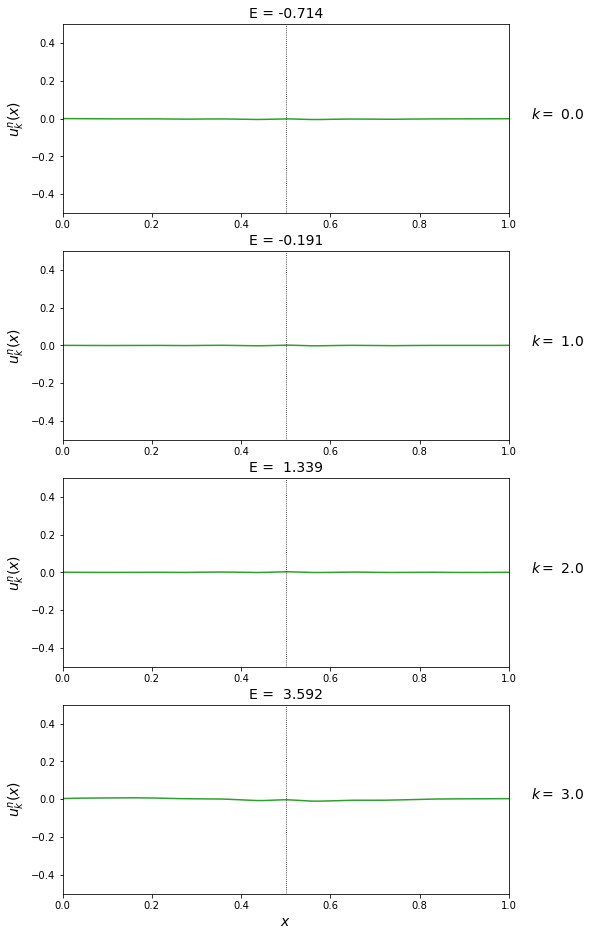

In [37]:
kvals = np.linspace(0,1*np.pi-0.1,numks)
knum = len(kvals)
fig, ax = plt.subplots(knum, 1, figsize=(8,4*knum), sharey=True)
modelxs = torch.linspace(0,1,1000).reshape(-1,1).cuda()
xval = np.linspace(-0.5,0.5,1000)


for i in range(len(kvals)):
    for n in range(1):
        modelks = torch.linspace(kvals[i],kvals[i],1000).reshape(-1,1).cuda()
        bloch, ek, nfe, delta  = bz1(modelxs,modelks)
        ukx, en = soln_coulomb.u_kn(xval,kvals[i],0)

#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,0].reshape(-1,1).cpu().detach().numpy(),color='C0')
#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,1].reshape(-1,1).cpu().detach().numpy(),color='C1')

#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,0].reshape(-1,1).cpu().detach().numpy(),color='C0')
#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,1].reshape(-1,1).cpu().detach().numpy(),color='C1')
        #ax[i].plot(modelxs.cpu().detach().numpy(),(bloch[:,0].reshape(-1,1).cpu().detach().numpy()**2)+(bloch[:,1].reshape(-1,1).cpu().detach().numpy()**2),color='C0')
        #ax[i].plot(xval+0.5,(np.real(ukx)**2+np.imag(ukx)**2),ls='--',color='C1')
        
        disgusting = (bloch.cpu().detach().numpy()[:,1])**2-(np.real((ukx))**2)+(bloch.cpu().detach().numpy()[:,0])**2-(np.imag((ukx))**2)
        ax[i].plot(modelxs.cpu().detach().numpy(),disgusting,color='C2')
        ax[i].set_xlim(0,1)
        ax[i].set_ylim(-0.5,0.5)
        ax[i].axvline(x=-0.5,ls=':',lw=0.8,c='k')
        ax[i].axvline(x=0.5,ls=':',lw=0.8,c='k')
        ax[i].set_title('E = {:6.3f}'.format(ek.cpu().detach().mean()),fontsize=14)
    ax[i].set_ylabel('$u_{k}^{n}(x)$',fontsize=14)
#for i in range(1):
ax[-1].set_xlabel('$x$',fontsize=14)
for i in range(knum):
    ax[i].annotate('$k=${:4.2}'.format(kvals[i]),(1.05,0.5),xycoords='axes fraction',fontsize=14)

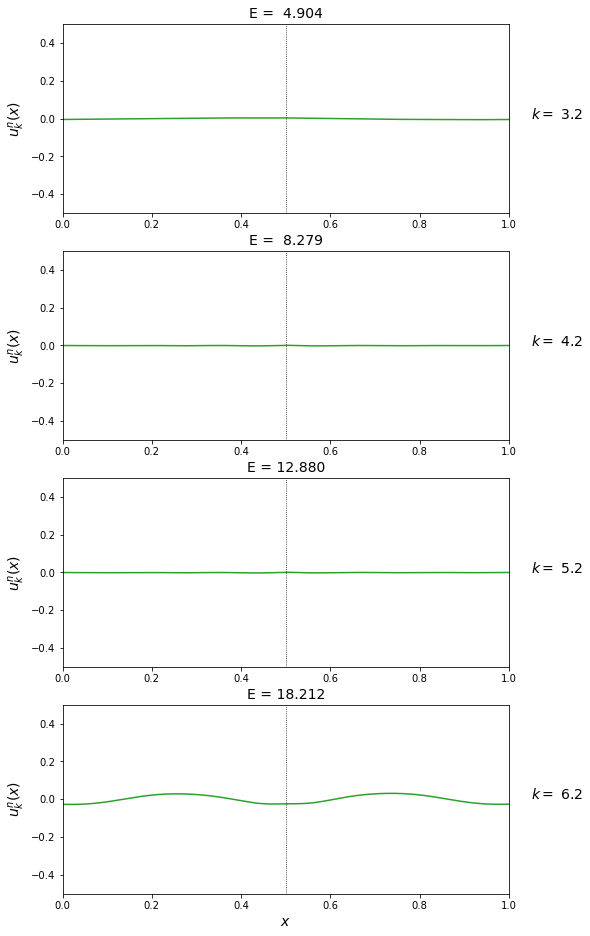

In [38]:
kvals = np.linspace(1*np.pi+0.1,2*np.pi-0.1,numks)
knum = len(kvals)
fig, ax = plt.subplots(knum, 1, figsize=(8,4*knum), sharey=True)
modelxs = torch.linspace(0,1,1000).reshape(-1,1).cuda()
xval = np.linspace(-0.5,0.5,1000)


for i in range(len(kvals)):
    for n in range(1):
        modelks = torch.linspace(kvals[i],kvals[i],1000).reshape(-1,1).cuda()
        bloch, ek, nfe, delta  = bz2(modelxs,modelks)
        ukx, en = soln_coulomb.u_kn(xval,kvals[i],1)

#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,0].reshape(-1,1).cpu().detach().numpy(),color='C0')
#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,1].reshape(-1,1).cpu().detach().numpy(),color='C1')

#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,0].reshape(-1,1).cpu().detach().numpy(),color='C0')
#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,1].reshape(-1,1).cpu().detach().numpy(),color='C1')
        #ax[i].plot(modelxs.cpu().detach().numpy(),(bloch[:,0].reshape(-1,1).cpu().detach().numpy()**2)+(bloch[:,1].reshape(-1,1).cpu().detach().numpy()**2),color='C0')
        #ax[i].plot(xval+0.5,(np.real(ukx)**2+np.imag(ukx)**2),ls='--',color='C1')
        
        disgusting = (bloch.cpu().detach().numpy()[:,1])**2-(np.real((ukx))**2)+(bloch.cpu().detach().numpy()[:,0])**2-(np.imag((ukx))**2)
        ax[i].plot(modelxs.cpu().detach().numpy(),disgusting,color='C2')
        ax[i].set_xlim(0,1)
        ax[i].set_ylim(-0.5,0.5)
        ax[i].axvline(x=-0.5,ls=':',lw=0.8,c='k')
        ax[i].axvline(x=0.5,ls=':',lw=0.8,c='k')
        ax[i].set_title('E = {:6.3f}'.format(ek.cpu().detach().mean()),fontsize=14)
    ax[i].set_ylabel('$u_{k}^{n}(x)$',fontsize=14)
#for i in range(1):
ax[-1].set_xlabel('$x$',fontsize=14)
for i in range(knum):
    ax[i].annotate('$k=${:4.2}'.format(kvals[i]),(1.05,0.5),xycoords='axes fraction',fontsize=14)

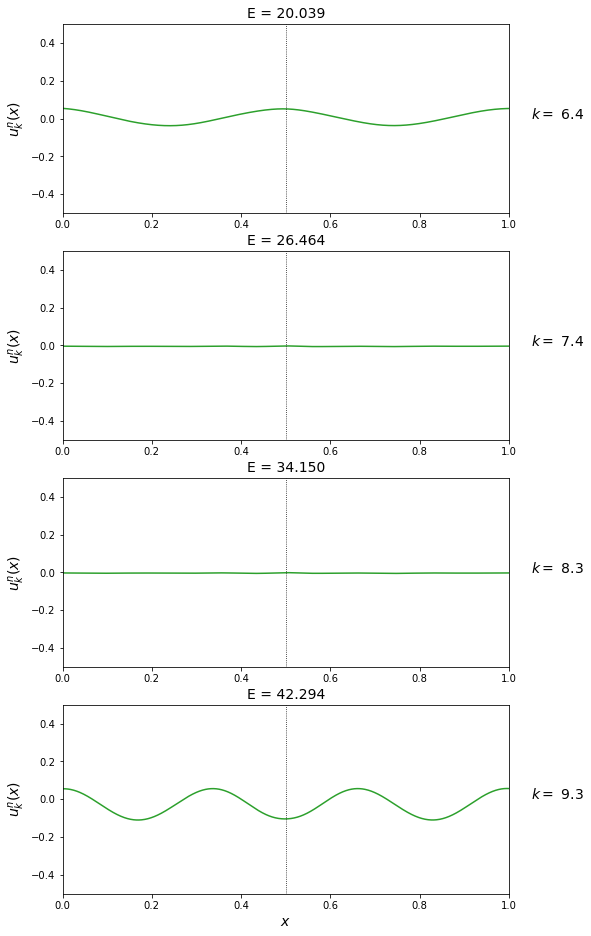

In [39]:
kvals = np.linspace(2*np.pi+0.1,3*np.pi-0.1,numks)
knum = len(kvals)
fig, ax = plt.subplots(knum, 1, figsize=(8,4*knum), sharey=True)
modelxs = torch.linspace(0,1,1000).reshape(-1,1).cuda()
xval = np.linspace(-0.5,0.5,1000)


for i in range(len(kvals)):
    for n in range(1):
        modelks = torch.linspace(kvals[i],kvals[i],1000).reshape(-1,1).cuda()
        bloch, ek, nfe, delta  = bz3(modelxs,modelks)
        ukx, en = soln_coulomb.u_kn(xval,kvals[i],2)

#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,0].reshape(-1,1).cpu().detach().numpy(),color='C0')
#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,1].reshape(-1,1).cpu().detach().numpy(),color='C1')

#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,0].reshape(-1,1).cpu().detach().numpy(),color='C0')
#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,1].reshape(-1,1).cpu().detach().numpy(),color='C1')
        #ax[i].plot(modelxs.cpu().detach().numpy(),(bloch[:,0].reshape(-1,1).cpu().detach().numpy()**2)+(bloch[:,1].reshape(-1,1).cpu().detach().numpy()**2),color='C0')
        #ax[i].plot(xval+0.5,(np.real(ukx)**2+np.imag(ukx)**2),ls='--',color='C1')
        
        disgusting = (bloch.cpu().detach().numpy()[:,1])**2-(np.real((ukx))**2)+(bloch.cpu().detach().numpy()[:,0])**2-(np.imag((ukx))**2)
        ax[i].plot(modelxs.cpu().detach().numpy(),disgusting,color='C2')
        ax[i].set_xlim(0,1)
        ax[i].set_ylim(-0.5,0.5)
        ax[i].axvline(x=-0.5,ls=':',lw=0.8,c='k')
        ax[i].axvline(x=0.5,ls=':',lw=0.8,c='k')
        ax[i].set_title('E = {:6.3f}'.format(ek.cpu().detach().mean()),fontsize=14)
    ax[i].set_ylabel('$u_{k}^{n}(x)$',fontsize=14)
#for i in range(1):
ax[-1].set_xlabel('$x$',fontsize=14)
for i in range(knum):
    ax[i].annotate('$k=${:4.2}'.format(kvals[i]),(1.05,0.5),xycoords='axes fraction',fontsize=14)

# Abs Error 

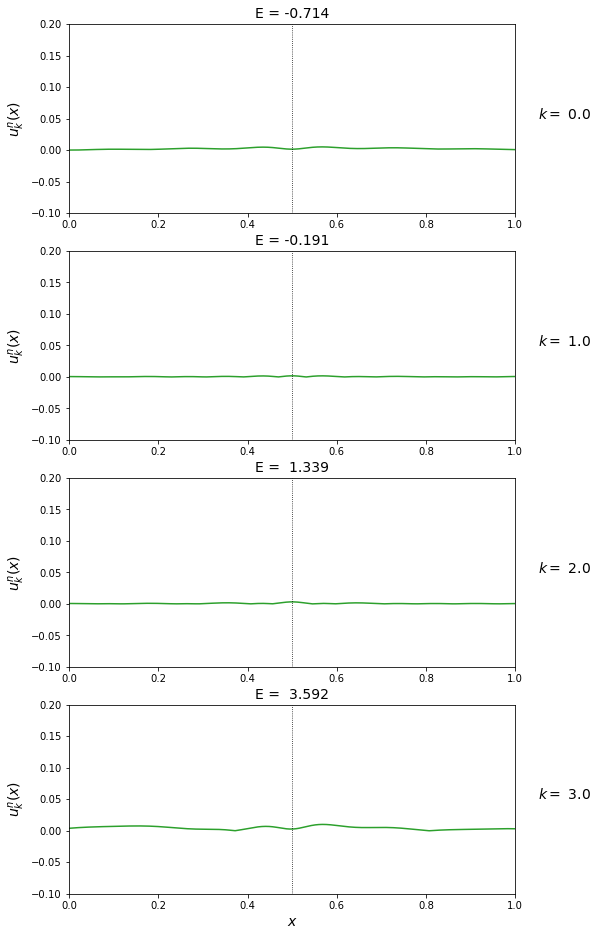

In [40]:
kvals = np.linspace(0,1*np.pi-0.1,numks)
knum = len(kvals)
fig, ax = plt.subplots(knum, 1, figsize=(8,4*knum), sharey=True)
modelxs = torch.linspace(0,1,1000).reshape(-1,1).cuda()
xval = np.linspace(-0.5,0.5,1000)


for i in range(len(kvals)):
    for n in range(1):
        modelks = torch.linspace(kvals[i],kvals[i],1000).reshape(-1,1).cuda()
        bloch, ek, nfe, delta  = bz1(modelxs,modelks)
        ukx, en = soln_coulomb.u_kn(xval,kvals[i],0)

#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,0].reshape(-1,1).cpu().detach().numpy(),color='C0')
#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,1].reshape(-1,1).cpu().detach().numpy(),color='C1')

#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,0].reshape(-1,1).cpu().detach().numpy(),color='C0')
#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,1].reshape(-1,1).cpu().detach().numpy(),color='C1')
        #ax[i].plot(modelxs.cpu().detach().numpy(),(bloch[:,0].reshape(-1,1).cpu().detach().numpy()**2)+(bloch[:,1].reshape(-1,1).cpu().detach().numpy()**2),color='C0')
        #ax[i].plot(xval+0.5,(np.real(ukx)**2+np.imag(ukx)**2),ls='--',color='C1')
        
        disgusting = (bloch.cpu().detach().numpy()[:,1])**2-(np.real((ukx))**2)+(bloch.cpu().detach().numpy()[:,0])**2-(np.imag((ukx))**2)
        ax[i].plot(modelxs.cpu().detach().numpy(),abs(disgusting),color='C2')
        ax[i].set_xlim(0,1)
        ax[i].set_ylim(-0.1,0.2)
        ax[i].axvline(x=-0.5,ls=':',lw=0.8,c='k')
        ax[i].axvline(x=0.5,ls=':',lw=0.8,c='k')
        ax[i].set_title('E = {:6.3f}'.format(ek.cpu().detach().mean()),fontsize=14)
    ax[i].set_ylabel('$u_{k}^{n}(x)$',fontsize=14)
#for i in range(1):
ax[-1].set_xlabel('$x$',fontsize=14)
for i in range(knum):
    ax[i].annotate('$k=${:4.2}'.format(kvals[i]),(1.05,0.5),xycoords='axes fraction',fontsize=14)

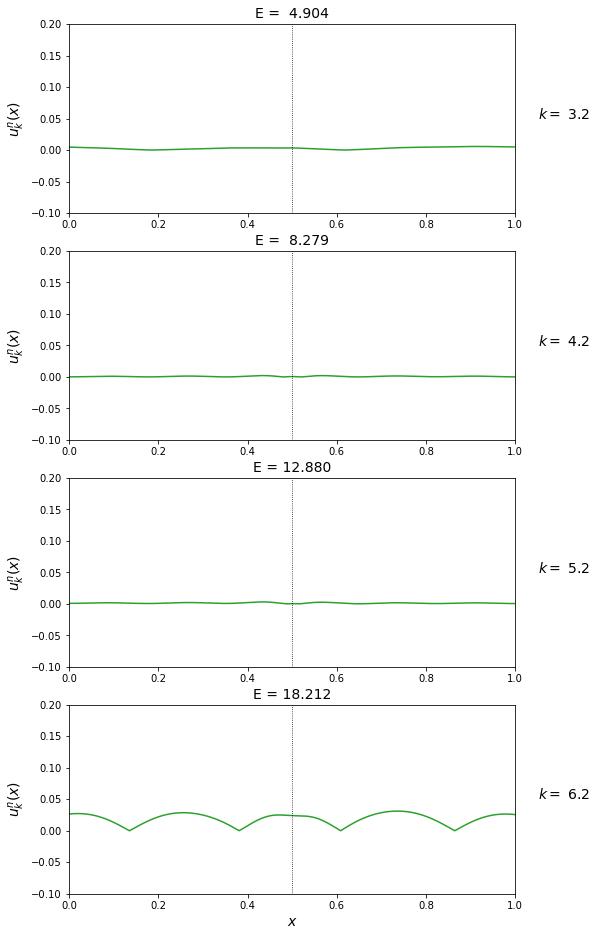

In [41]:
kvals = np.linspace(1*np.pi+0.1,2*np.pi-0.1,numks)
knum = len(kvals)
fig, ax = plt.subplots(knum, 1, figsize=(8,4*knum), sharey=True)
modelxs = torch.linspace(0,1,1000).reshape(-1,1).cuda()
xval = np.linspace(-0.5,0.5,1000)


for i in range(len(kvals)):
    for n in range(1):
        modelks = torch.linspace(kvals[i],kvals[i],1000).reshape(-1,1).cuda()
        bloch, ek, nfe, delta  = bz2(modelxs,modelks)
        ukx, en = soln_coulomb.u_kn(xval,kvals[i],1)

#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,0].reshape(-1,1).cpu().detach().numpy(),color='C0')
#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,1].reshape(-1,1).cpu().detach().numpy(),color='C1')

#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,0].reshape(-1,1).cpu().detach().numpy(),color='C0')
#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,1].reshape(-1,1).cpu().detach().numpy(),color='C1')
        #ax[i].plot(modelxs.cpu().detach().numpy(),(bloch[:,0].reshape(-1,1).cpu().detach().numpy()**2)+(bloch[:,1].reshape(-1,1).cpu().detach().numpy()**2),color='C0')
        #ax[i].plot(xval+0.5,(np.real(ukx)**2+np.imag(ukx)**2),ls='--',color='C1')
        
        disgusting = (bloch.cpu().detach().numpy()[:,1])**2-(np.real((ukx))**2)+(bloch.cpu().detach().numpy()[:,0])**2-(np.imag((ukx))**2)
        ax[i].plot(modelxs.cpu().detach().numpy(),abs(disgusting),color='C2')
        ax[i].set_xlim(0,1)
        ax[i].set_ylim(-0.1,0.2)
        ax[i].axvline(x=-0.5,ls=':',lw=0.8,c='k')
        ax[i].axvline(x=0.5,ls=':',lw=0.8,c='k')
        ax[i].set_title('E = {:6.3f}'.format(ek.cpu().detach().mean()),fontsize=14)
    ax[i].set_ylabel('$u_{k}^{n}(x)$',fontsize=14)
#for i in range(1):
ax[-1].set_xlabel('$x$',fontsize=14)
for i in range(knum):
    ax[i].annotate('$k=${:4.2}'.format(kvals[i]),(1.05,0.5),xycoords='axes fraction',fontsize=14)

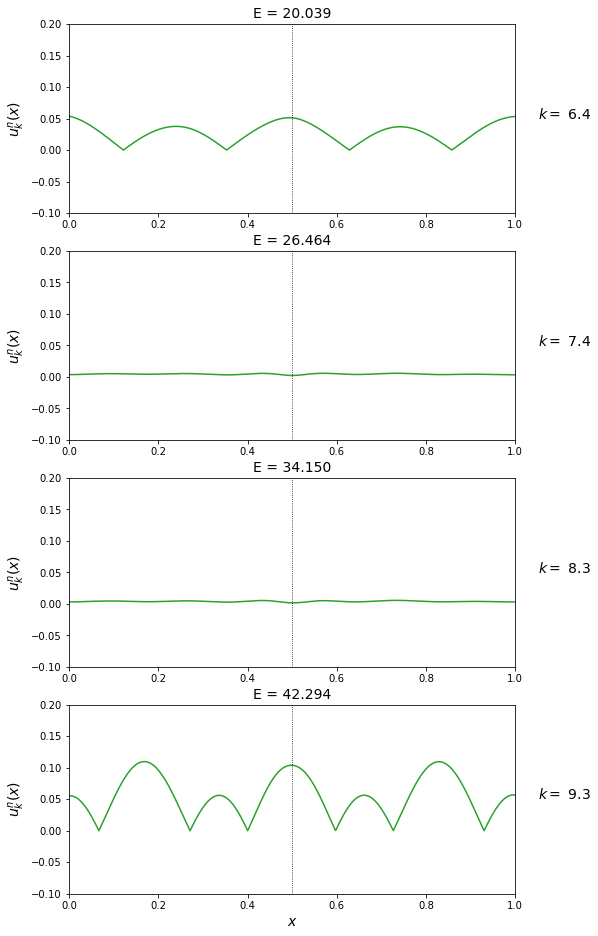

In [42]:
kvals = np.linspace(2*np.pi+0.1,3*np.pi-0.1,numks)
knum = len(kvals)
fig, ax = plt.subplots(knum, 1, figsize=(8,4*knum), sharey=True)
modelxs = torch.linspace(0,1,1000).reshape(-1,1).cuda()
xval = np.linspace(-0.5,0.5,1000)


for i in range(len(kvals)):
    for n in range(1):
        modelks = torch.linspace(kvals[i],kvals[i],1000).reshape(-1,1).cuda()
        bloch, ek, nfe, delta  = bz3(modelxs,modelks)
        ukx, en = soln_coulomb.u_kn(xval,kvals[i],2)

#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,0].reshape(-1,1).cpu().detach().numpy(),color='C0')
#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,1].reshape(-1,1).cpu().detach().numpy(),color='C1')

#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,0].reshape(-1,1).cpu().detach().numpy(),color='C0')
#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,1].reshape(-1,1).cpu().detach().numpy(),color='C1')
        #ax[i].plot(modelxs.cpu().detach().numpy(),(bloch[:,0].reshape(-1,1).cpu().detach().numpy()**2)+(bloch[:,1].reshape(-1,1).cpu().detach().numpy()**2),color='C0')
        #ax[i].plot(xval+0.5,(np.real(ukx)**2+np.imag(ukx)**2),ls='--',color='C1')
        
        disgusting = (bloch.cpu().detach().numpy()[:,1])**2-(np.real((ukx))**2)+(bloch.cpu().detach().numpy()[:,0])**2-(np.imag((ukx))**2)
        ax[i].plot(modelxs.cpu().detach().numpy(),abs(disgusting),color='C2')
        ax[i].set_xlim(0,1)
        ax[i].set_ylim(-0.1,0.2)
        ax[i].axvline(x=-0.5,ls=':',lw=0.8,c='k')
        ax[i].axvline(x=0.5,ls=':',lw=0.8,c='k')
        ax[i].set_title('E = {:6.3f}'.format(ek.cpu().detach().mean()),fontsize=14)
    ax[i].set_ylabel('$u_{k}^{n}(x)$',fontsize=14)
#for i in range(1):
ax[-1].set_xlabel('$x$',fontsize=14)
for i in range(knum):
    ax[i].annotate('$k=${:4.2}'.format(kvals[i]),(1.05,0.5),xycoords='axes fraction',fontsize=14)

# Squared Error

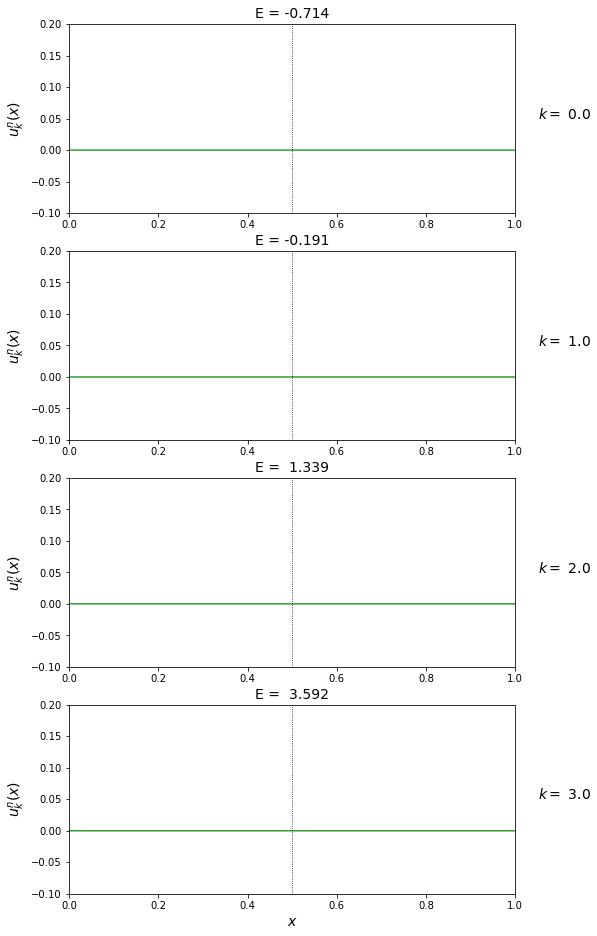

In [43]:
kvals = np.linspace(0,1*np.pi-0.1,numks)
knum = len(kvals)
fig, ax = plt.subplots(knum, 1, figsize=(8,4*knum), sharey=True)
modelxs = torch.linspace(0,1,1000).reshape(-1,1).cuda()
xval = np.linspace(-0.5,0.5,1000)


for i in range(len(kvals)):
    for n in range(1):
        modelks = torch.linspace(kvals[i],kvals[i],1000).reshape(-1,1).cuda()
        bloch, ek, nfe, delta  = bz1(modelxs,modelks)
        ukx, en = soln_coulomb.u_kn(xval,kvals[i],0)

#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,0].reshape(-1,1).cpu().detach().numpy(),color='C0')
#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,1].reshape(-1,1).cpu().detach().numpy(),color='C1')

#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,0].reshape(-1,1).cpu().detach().numpy(),color='C0')
#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,1].reshape(-1,1).cpu().detach().numpy(),color='C1')
        #ax[i].plot(modelxs.cpu().detach().numpy(),(bloch[:,0].reshape(-1,1).cpu().detach().numpy()**2)+(bloch[:,1].reshape(-1,1).cpu().detach().numpy()**2),color='C0')
        #ax[i].plot(xval+0.5,(np.real(ukx)**2+np.imag(ukx)**2),ls='--',color='C1')
        
        disgusting = (bloch.cpu().detach().numpy()[:,1])**2-(np.real((ukx))**2)+(bloch.cpu().detach().numpy()[:,0])**2-(np.imag((ukx))**2)
        ax[i].plot(modelxs.cpu().detach().numpy(),(disgusting)**2,color='C2')
        ax[i].set_xlim(0,1)
        ax[i].set_ylim(-0.1,0.2)
        ax[i].axvline(x=-0.5,ls=':',lw=0.8,c='k')
        ax[i].axvline(x=0.5,ls=':',lw=0.8,c='k')
        ax[i].set_title('E = {:6.3f}'.format(ek.cpu().detach().mean()),fontsize=14)
    ax[i].set_ylabel('$u_{k}^{n}(x)$',fontsize=14)
#for i in range(1):
ax[-1].set_xlabel('$x$',fontsize=14)
for i in range(knum):
    ax[i].annotate('$k=${:4.2}'.format(kvals[i]),(1.05,0.5),xycoords='axes fraction',fontsize=14)

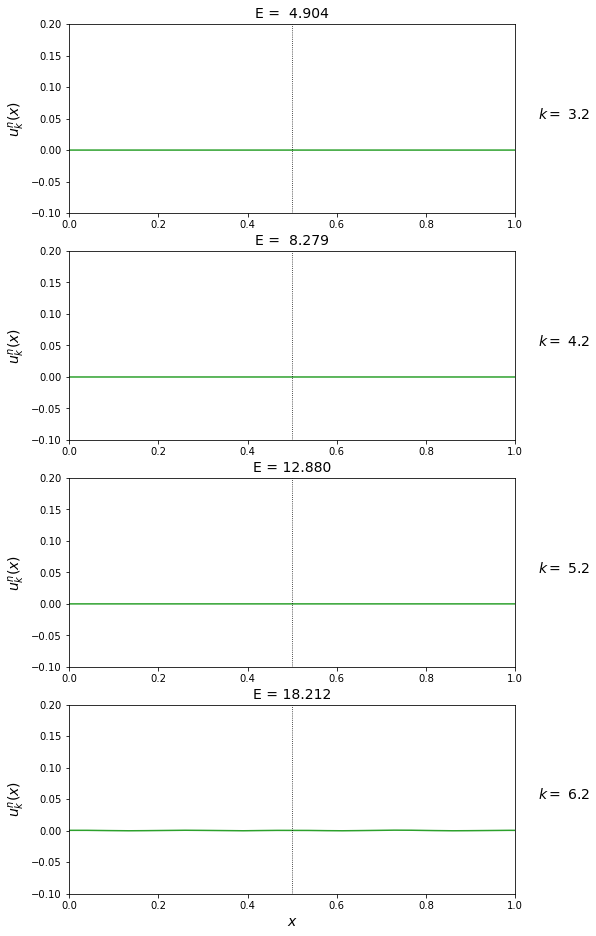

In [44]:
kvals = np.linspace(1*np.pi+0.1,2*np.pi-0.1,numks)
knum = len(kvals)
fig, ax = plt.subplots(knum, 1, figsize=(8,4*knum), sharey=True)
modelxs = torch.linspace(0,1,1000).reshape(-1,1).cuda()
xval = np.linspace(-0.5,0.5,1000)


for i in range(len(kvals)):
    for n in range(1):
        modelks = torch.linspace(kvals[i],kvals[i],1000).reshape(-1,1).cuda()
        bloch, ek, nfe, delta  = bz2(modelxs,modelks)
        ukx, en = soln_coulomb.u_kn(xval,kvals[i],1)

#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,0].reshape(-1,1).cpu().detach().numpy(),color='C0')
#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,1].reshape(-1,1).cpu().detach().numpy(),color='C1')

#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,0].reshape(-1,1).cpu().detach().numpy(),color='C0')
#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,1].reshape(-1,1).cpu().detach().numpy(),color='C1')
        #ax[i].plot(modelxs.cpu().detach().numpy(),(bloch[:,0].reshape(-1,1).cpu().detach().numpy()**2)+(bloch[:,1].reshape(-1,1).cpu().detach().numpy()**2),color='C0')
        #ax[i].plot(xval+0.5,(np.real(ukx)**2+np.imag(ukx)**2),ls='--',color='C1')
        
        disgusting = (bloch.cpu().detach().numpy()[:,1])**2-(np.real((ukx))**2)+(bloch.cpu().detach().numpy()[:,0])**2-(np.imag((ukx))**2)
        ax[i].plot(modelxs.cpu().detach().numpy(),(disgusting)**2,color='C2')
        ax[i].set_xlim(0,1)
        ax[i].set_ylim(-0.1,0.2)
        ax[i].axvline(x=-0.5,ls=':',lw=0.8,c='k')
        ax[i].axvline(x=0.5,ls=':',lw=0.8,c='k')
        ax[i].set_title('E = {:6.3f}'.format(ek.cpu().detach().mean()),fontsize=14)
    ax[i].set_ylabel('$u_{k}^{n}(x)$',fontsize=14)
#for i in range(1):
ax[-1].set_xlabel('$x$',fontsize=14)
for i in range(knum):
    ax[i].annotate('$k=${:4.2}'.format(kvals[i]),(1.05,0.5),xycoords='axes fraction',fontsize=14)

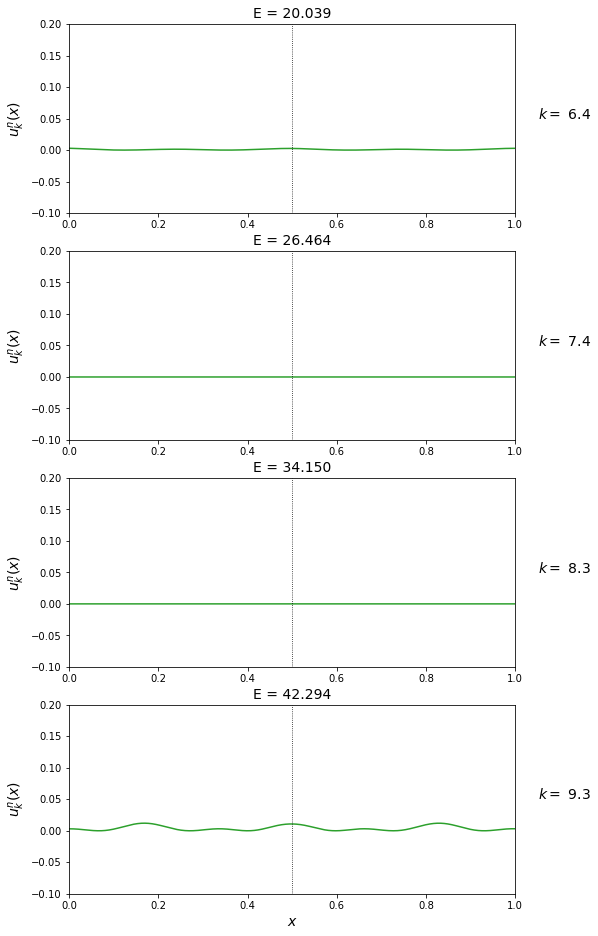

In [45]:
kvals = np.linspace(2*np.pi+0.1,3*np.pi-0.1,numks)
knum = len(kvals)
fig, ax = plt.subplots(knum, 1, figsize=(8,4*knum), sharey=True)
modelxs = torch.linspace(0,1,1000).reshape(-1,1).cuda()
xval = np.linspace(-0.5,0.5,1000)


for i in range(len(kvals)):
    for n in range(1):
        modelks = torch.linspace(kvals[i],kvals[i],1000).reshape(-1,1).cuda()
        bloch, ek, nfe, delta  = bz3(modelxs,modelks)
        ukx, en = soln_coulomb.u_kn(xval,kvals[i],2)

#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,0].reshape(-1,1).cpu().detach().numpy(),color='C0')
#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,1].reshape(-1,1).cpu().detach().numpy(),color='C1')

#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,0].reshape(-1,1).cpu().detach().numpy(),color='C0')
#         ax[i].plot(modelxs.cpu().detach().numpy(),bloch[:,1].reshape(-1,1).cpu().detach().numpy(),color='C1')
        #ax[i].plot(modelxs.cpu().detach().numpy(),(bloch[:,0].reshape(-1,1).cpu().detach().numpy()**2)+(bloch[:,1].reshape(-1,1).cpu().detach().numpy()**2),color='C0')
        #ax[i].plot(xval+0.5,(np.real(ukx)**2+np.imag(ukx)**2),ls='--',color='C1')
        
        disgusting = (bloch.cpu().detach().numpy()[:,1])**2-(np.real((ukx))**2)+(bloch.cpu().detach().numpy()[:,0])**2-(np.imag((ukx))**2)
        ax[i].plot(modelxs.cpu().detach().numpy(),(disgusting)**2,color='C2')
        ax[i].set_xlim(0,1)
        ax[i].set_ylim(-0.1,0.2)
        ax[i].axvline(x=-0.5,ls=':',lw=0.8,c='k')
        ax[i].axvline(x=0.5,ls=':',lw=0.8,c='k')
        ax[i].set_title('E = {:6.3f}'.format(ek.cpu().detach().mean()),fontsize=14)
    ax[i].set_ylabel('$u_{k}^{n}(x)$',fontsize=14)
#for i in range(1):
ax[-1].set_xlabel('$x$',fontsize=14)
for i in range(knum):
    ax[i].annotate('$k=${:4.2}'.format(kvals[i]),(1.05,0.5),xycoords='axes fraction',fontsize=14)

# MSE

In [46]:
# Build mean squared array 

meanSquared = []
meanSquaredX = []
# bz1 
kvals = np.linspace(0,1*np.pi-0.01,50)
knum = len(kvals)
modelxs = torch.linspace(0,1,1000).reshape(-1,1).cuda()
xval = np.linspace(-0.5,0.5,1000)

for i in range(len(kvals)):
    modelks = torch.linspace(kvals[i],kvals[i],1000).reshape(-1,1).cuda()
    bloch, ek, nfe, delta  = bz1(modelxs,modelks)
    ukx, en = soln_coulomb.u_kn(xval,kvals[i],0)

    disgusting = np.mean((bloch.cpu().detach().numpy()[:,1])**2-(np.real((ukx))**2)+(bloch.cpu().detach().numpy()[:,0])**2-(np.imag((ukx))**2))
    meanSquaredX.append(kvals[i])
    meanSquared.append(disgusting**2)

# bz2
kvals = np.linspace(0.01+np.pi,2*np.pi-0.01,50)
knum = len(kvals)

for i in range(len(kvals)):
    modelks = torch.linspace(kvals[i],kvals[i],1000).reshape(-1,1).cuda()
    bloch, ek, nfe, delta  = bz2(modelxs,modelks)
    ukx, en = soln_coulomb.u_kn(xval,kvals[i],1)

    disgusting = np.mean((bloch.cpu().detach().numpy()[:,1])**2-(np.real((ukx))**2)+(bloch.cpu().detach().numpy()[:,0])**2-(np.imag((ukx))**2))
    meanSquaredX.append(kvals[i])
    meanSquared.append(disgusting**2)
# bz3
kvals = np.linspace(0.01+2*np.pi,3*np.pi-0.01,50)
knum = len(kvals)

for i in range(len(kvals)):
    modelks = torch.linspace(kvals[i],kvals[i],1000).reshape(-1,1).cuda()
    bloch, ek, nfe, delta  = bz3(modelxs,modelks)
    ukx, en = soln_coulomb.u_kn(xval,kvals[i],2)

    disgusting = np.mean((bloch.cpu().detach().numpy()[:,1])**2-(np.real((ukx))**2)+(bloch.cpu().detach().numpy()[:,0])**2-(np.imag((ukx))**2))
    meanSquaredX.append(kvals[i])
    meanSquared.append(disgusting**2)

In [47]:
print(meanSquaredX)

[0.0, 0.06391005415489374, 0.1278201083097875, 0.19173016246468122, 0.255640216619575, 0.31955027077446874, 0.38346032492936244, 0.4473703790842562, 0.51128043323915, 0.5751904873940437, 0.6391005415489375, 0.7030105957038312, 0.7669206498587249, 0.8308307040136187, 0.8947407581685124, 0.9586508123234062, 1.0225608664783, 1.0864709206331937, 1.1503809747880873, 1.2142910289429811, 1.278201083097875, 1.3421111372527685, 1.4060211914076624, 1.4699312455625562, 1.5338412997174498, 1.5977513538723436, 1.6616614080272374, 1.7255714621821312, 1.7894815163370248, 1.8533915704919186, 1.9173016246468124, 1.981211678801706, 2.0451217329566, 2.1090317871114936, 2.1729418412663875, 2.2368518954212813, 2.3007619495761746, 2.3646720037310685, 2.4285820578859623, 2.492492112040856, 2.55640216619575, 2.6203122203506437, 2.684222274505537, 2.748132328660431, 2.8120423828153247, 2.8759524369702185, 2.9398624911251123, 3.003772545280006, 3.0676825994348995, 3.1315926535897933, 3.151592653589793, 3.215298

In [48]:
print(meanSquared)

[5.449189918543395e-06, 4.661770469145067e-06, 4.086473465022858e-06, 3.2750898231425186e-06, 1.958818825836892e-06, 6.790993718957307e-07, 8.46498824590678e-08, 5.659320560098858e-10, 9.332021449632775e-09, 1.1880457199443103e-11, 3.2299504858241766e-08, 1.1096327321348794e-07, 1.481292427592588e-07, 9.670527705218277e-08, 2.56278724075276e-08, 1.1603129798511116e-09, 2.256573294438352e-09, 7.22319057281436e-08, 4.2581169731788346e-07, 9.492226226571042e-07, 8.572418831769882e-07, 1.9815370398751653e-07, 2.3958122760095313e-08, 2.502111319038931e-07, 2.6489003072588515e-07, 1.0150141952759737e-07, 2.7185413456405274e-09, 7.594826880563902e-08, 4.4924105744078954e-08, 2.5528210477116034e-07, 1.6578164279187197e-06, 1.3975026127206104e-06, 8.39524369624567e-09, 1.1699239514470131e-07, 1.0377521371191623e-07, 3.2691312194395065e-08, 1.6766246683675766e-06, 4.277179583946685e-06, 9.693860583439276e-07, 1.3405830616468903e-07, 1.889323321396997e-08, 4.99651467237065e-07, 1.0301707356121957

Text(0.5, 1.0, 'Bloch Function - Mean Squared Error')

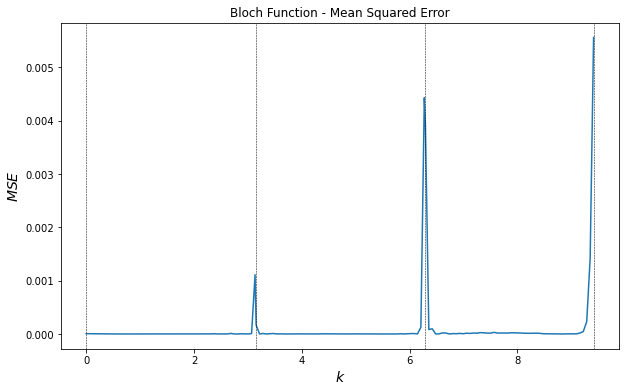

In [49]:
plt.figure(figsize=(10,6))
plt.plot(meanSquaredX, meanSquared,ls='-',color='C0')
plt.axvline(x=0,lw=0.5,c='k',ls='--')
plt.axvline(x=np.pi,lw=0.5,c='k',ls='--')
plt.axvline(x=2*np.pi,lw=0.5,c='k',ls='--')
plt.axvline(x=3*np.pi,lw=0.5,c='k',ls='--')
#plt.ylim(-2,20);plt.xlim(-2*np.pi-0.5,2*np.pi+0.5)
plt.xlabel('$k$',fontsize=14)
plt.ylabel('$MSE$',fontsize=14)
plt.title('Bloch Function - Mean Squared Error')

Text(0.5, 1.0, 'Bloch Function - Root Mean Squared Error')

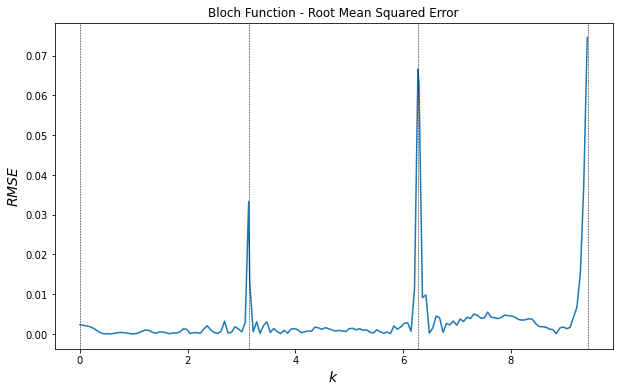

In [50]:
plt.figure(figsize=(10,6))
plt.plot(meanSquaredX, np.sqrt(meanSquared),ls='-',color='C0')
plt.axvline(x=0,lw=0.5,c='k',ls='--')
plt.axvline(x=np.pi,lw=0.5,c='k',ls='--')
plt.axvline(x=2*np.pi,lw=0.5,c='k',ls='--')
plt.axvline(x=3*np.pi,lw=0.5,c='k',ls='--')
#plt.ylim(-2,20);plt.xlim(-2*np.pi-0.5,2*np.pi+0.5)
plt.xlabel('$k$',fontsize=14)
plt.ylabel('$RMSE$',fontsize=14)
plt.title('Bloch Function - Root Mean Squared Error')